In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyro
from pyro import distributions as dist
import torch
from torch.nn import functional as tf
from pyro.infer import SVI, TracePredictive, Trace_ELBO, EmpiricalMarginal
from pyro.infer.mcmc import MCMC, NUTS

%matplotlib inline

In [2]:
data = pd.read_csv("data/height-weight/NHIS 2007 data.csv", usecols=["SEX", "height", "weight"])
data.columns = ['sex', 'height', 'weight']
# Filter out unknown values
data = data[(data['weight'] < 500) & (data['height'] < 90)]
n_train = len(data) * 3 // 4
train_data, test_data = data[:n_train], data[n_train:]
data.head()

,sex,height,weight
0,1,74,260
1,1,70,185
2,2,61,170
3,1,68,175
4,2,66,168


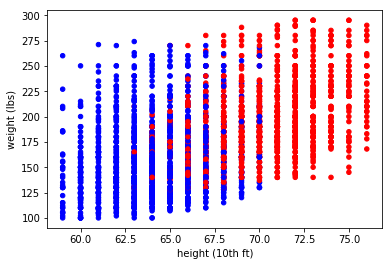

In [3]:
col = train_data['sex'].map({1: 'r', 2: 'b'})
train_data.plot.scatter(x='height', y='weight', color=col)
plt.xlabel('height (10th ft)')
plt.ylabel('weight (lbs)')
plt.show()

We would like to use Bayesian logistic regression to identify the most likely sex of a person given their weight and height.

\begin{gather*}
\mathrm{male?} = \sigma(a_1 * \mathrm{weight} + a_2 * \mathrm{height} + a_0)
\end{gather*}

Below we see an example probabilistic Python program that tries to model the parameters of the logistic regression.

In [4]:
def model(height, weight, sex=None):
    a = pyro.sample('a', dist.MultivariateNormal(torch.zeros(3), torch.eye(3)))
    datavec = torch.stack([torch.ones_like(height), height, weight], dim=-1).float()
    reg = a @ datavec.t()
    if sex is not None:
        sex = (sex == 1).float()
    return pyro.sample('sex', dist.Bernoulli(logits=reg), obs=sex)

In [5]:
height = torch.tensor(train_data['height'].values)
weight = torch.tensor(train_data['weight'].values)
sex = torch.tensor(train_data['sex'].values)
nuts_kernel = NUTS(model)
posterior = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200).run(height, weight, sex=sex)

Warmup:   0%|          | 0/1200 [00:00<?, ?it/s]

Warmup:   0%|          | 0/1200 [00:00<?, ?it/s, step size=2.81e-02, acc. rate=1.000]

Warmup:   0%|          | 1/1200 [00:00<03:13,  6.19it/s, step size=2.81e-02, acc. rate=1.000]

Warmup:   0%|          | 1/1200 [00:00<03:13,  6.19it/s, step size=4.75e-03, acc. rate=0.500]

Warmup:   0%|          | 2/1200 [00:00<03:13,  6.19it/s, step size=4.68e-04, acc. rate=0.333]

Warmup:   0%|          | 3/1200 [00:00<03:13,  6.19it/s, step size=6.33e-04, acc. rate=0.500]

Warmup:   0%|          | 4/1200 [00:00<03:13,  6.19it/s, step size=3.67e-04, acc. rate=0.600]

Warmup:   0%|          | 5/1200 [00:00<02:25,  8.21it/s, step size=3.67e-04, acc. rate=0.600]

Warmup:   0%|          | 5/1200 [00:00<02:25,  8.21it/s, step size=1.31e-04, acc. rate=0.667]

Warmup:   0%|          | 6/1200 [00:00<02:25,  8.21it/s, step size=1.46e-04, acc. rate=0.714]

Warmup:   1%|          | 7/1200 [00:00<02:10,  9.18it/s, step size=1.46e-04, acc. rate=0.714]

Warmup:   1%|          | 7/1200 [00:00<02:10,  9.18it/s, step size=2.61e-04, acc. rate=0.750]

Warmup:   1%|          | 8/1200 [00:00<02:09,  9.18it/s, step size=4.74e-04, acc. rate=0.778]

Warmup:   1%|          | 9/1200 [00:00<02:09,  9.18it/s, step size=1.38e-04, acc. rate=0.800]

Warmup:   1%|          | 10/1200 [00:00<02:09,  9.18it/s, step size=2.61e-04, acc. rate=0.818]

Warmup:   1%|          | 11/1200 [00:00<01:42, 11.60it/s, step size=2.61e-04, acc. rate=0.818]

Warmup:   1%|          | 11/1200 [00:00<01:42, 11.60it/s, step size=4.88e-04, acc. rate=0.833]

Warmup:   1%|          | 12/1200 [00:00<01:42, 11.60it/s, step size=4.10e-05, acc. rate=0.769]

Warmup:   1%|          | 13/1200 [00:00<01:42, 11.60it/s, step size=7.76e-05, acc. rate=0.786]

Warmup:   1%|          | 14/1200 [00:00<01:26, 13.71it/s, step size=7.76e-05, acc. rate=0.786]

Warmup:   1%|          | 14/1200 [00:00<01:26, 13.71it/s, step size=1.49e-04, acc. rate=0.800]

Warmup:   1%|▏         | 15/1200 [00:01<01:26, 13.71it/s, step size=2.17e-04, acc. rate=0.812]

Warmup:   1%|▏         | 16/1200 [00:01<02:00,  9.82it/s, step size=2.17e-04, acc. rate=0.812]

Warmup:   1%|▏         | 16/1200 [00:01<02:00,  9.82it/s, step size=4.13e-04, acc. rate=0.824]

Warmup:   1%|▏         | 17/1200 [00:01<02:00,  9.82it/s, step size=8.30e-05, acc. rate=0.833]

Warmup:   2%|▏         | 18/1200 [00:01<01:46, 11.06it/s, step size=8.30e-05, acc. rate=0.833]

Warmup:   2%|▏         | 18/1200 [00:01<01:46, 11.06it/s, step size=1.58e-04, acc. rate=0.842]

Warmup:   2%|▏         | 19/1200 [00:01<01:46, 11.06it/s, step size=2.93e-04, acc. rate=0.850]

Warmup:   2%|▏         | 20/1200 [00:01<02:45,  7.13it/s, step size=2.93e-04, acc. rate=0.850]

Warmup:   2%|▏         | 20/1200 [00:01<02:45,  7.13it/s, step size=5.23e-04, acc. rate=0.857]

Warmup:   2%|▏         | 21/1200 [00:01<02:45,  7.13it/s, step size=1.16e-04, acc. rate=0.818]

Warmup:   2%|▏         | 22/1200 [00:01<02:45,  7.13it/s, step size=2.10e-04, acc. rate=0.826]

Warmup:   2%|▏         | 23/1200 [00:01<02:09,  9.07it/s, step size=2.10e-04, acc. rate=0.826]

Warmup:   2%|▏         | 23/1200 [00:02<02:09,  9.07it/s, step size=1.86e-04, acc. rate=0.833]

Warmup:   2%|▏         | 24/1200 [00:02<02:09,  9.07it/s, step size=3.43e-04, acc. rate=0.840]

Warmup:   2%|▏         | 25/1200 [00:02<02:52,  6.83it/s, step size=3.43e-04, acc. rate=0.840]

Warmup:   2%|▏         | 25/1200 [00:02<02:52,  6.83it/s, step size=1.59e-04, acc. rate=0.846]

Warmup:   2%|▏         | 26/1200 [00:02<02:51,  6.83it/s, step size=2.87e-04, acc. rate=0.852]

Warmup:   2%|▏         | 27/1200 [00:02<02:22,  8.24it/s, step size=2.87e-04, acc. rate=0.852]

Warmup:   2%|▏         | 27/1200 [00:02<02:22,  8.24it/s, step size=4.62e-04, acc. rate=0.857]

Warmup:   2%|▏         | 28/1200 [00:02<02:22,  8.24it/s, step size=5.79e-05, acc. rate=0.828]

Warmup:   2%|▏         | 29/1200 [00:02<02:53,  6.74it/s, step size=5.79e-05, acc. rate=0.828]

Warmup:   2%|▏         | 29/1200 [00:04<02:53,  6.74it/s, step size=9.99e-05, acc. rate=0.833]

Warmup:   2%|▎         | 30/1200 [00:05<02:53,  6.74it/s, step size=1.78e-04, acc. rate=0.839]

Warmup:   3%|▎         | 31/1200 [00:05<09:15,  2.11it/s, step size=1.78e-04, acc. rate=0.839]

Warmup:   3%|▎         | 31/1200 [00:05<09:15,  2.11it/s, step size=2.78e-04, acc. rate=0.844]

Warmup:   3%|▎         | 32/1200 [00:05<07:39,  2.54it/s, step size=2.78e-04, acc. rate=0.844]

Warmup:   3%|▎         | 32/1200 [00:05<07:39,  2.54it/s, step size=2.02e-04, acc. rate=0.848]

Warmup:   3%|▎         | 33/1200 [00:05<06:07,  3.18it/s, step size=2.02e-04, acc. rate=0.848]

Warmup:   3%|▎         | 33/1200 [00:05<06:07,  3.18it/s, step size=3.57e-04, acc. rate=0.853]

Warmup:   3%|▎         | 34/1200 [00:06<06:07,  3.18it/s, step size=3.43e-04, acc. rate=0.857]

Warmup:   3%|▎         | 35/1200 [00:06<05:30,  3.52it/s, step size=3.43e-04, acc. rate=0.857]

Warmup:   3%|▎         | 35/1200 [00:06<05:30,  3.52it/s, step size=4.85e-04, acc. rate=0.861]

Warmup:   3%|▎         | 36/1200 [00:06<05:30,  3.52it/s, step size=8.37e-04, acc. rate=0.865]

Warmup:   3%|▎         | 37/1200 [00:06<05:29,  3.52it/s, step size=1.10e-04, acc. rate=0.842]

Warmup:   3%|▎         | 38/1200 [00:06<05:29,  3.52it/s, step size=1.72e-04, acc. rate=0.846]

Warmup:   3%|▎         | 39/1200 [00:06<04:00,  4.83it/s, step size=1.72e-04, acc. rate=0.846]

Warmup:   3%|▎         | 39/1200 [00:06<04:00,  4.83it/s, step size=2.95e-04, acc. rate=0.850]

Warmup:   3%|▎         | 40/1200 [00:06<04:00,  4.83it/s, step size=1.51e-04, acc. rate=0.854]

Warmup:   3%|▎         | 41/1200 [00:06<03:10,  6.09it/s, step size=1.51e-04, acc. rate=0.854]

Warmup:   3%|▎         | 41/1200 [00:06<03:10,  6.09it/s, step size=2.45e-04, acc. rate=0.857]

Warmup:   4%|▎         | 42/1200 [00:07<03:10,  6.09it/s, step size=3.78e-04, acc. rate=0.860]

Warmup:   4%|▎         | 43/1200 [00:07<06:04,  3.17it/s, step size=3.78e-04, acc. rate=0.860]

Warmup:   4%|▎         | 43/1200 [00:07<06:04,  3.17it/s, step size=3.74e-04, acc. rate=0.864]

Warmup:   4%|▎         | 44/1200 [00:07<06:04,  3.17it/s, step size=2.03e-04, acc. rate=0.867]

Warmup:   4%|▍         | 45/1200 [00:07<04:54,  3.93it/s, step size=2.03e-04, acc. rate=0.867]

Warmup:   4%|▍         | 45/1200 [00:07<04:54,  3.93it/s, step size=2.58e-04, acc. rate=0.870]

Warmup:   4%|▍         | 46/1200 [00:07<04:53,  3.93it/s, step size=1.50e-04, acc. rate=0.872]

Warmup:   4%|▍         | 47/1200 [00:07<03:50,  5.00it/s, step size=1.50e-04, acc. rate=0.872]

Warmup:   4%|▍         | 47/1200 [00:08<03:50,  5.00it/s, step size=2.50e-04, acc. rate=0.875]

Warmup:   4%|▍         | 48/1200 [00:08<03:50,  5.00it/s, step size=4.13e-04, acc. rate=0.878]

Warmup:   4%|▍         | 49/1200 [00:08<05:08,  3.73it/s, step size=4.13e-04, acc. rate=0.878]

Warmup:   4%|▍         | 49/1200 [00:08<05:08,  3.73it/s, step size=6.43e-05, acc. rate=0.860]

Warmup:   4%|▍         | 50/1200 [00:09<05:07,  3.73it/s, step size=1.07e-04, acc. rate=0.863]

Warmup:   4%|▍         | 51/1200 [00:09<06:51,  2.79it/s, step size=1.07e-04, acc. rate=0.863]

Warmup:   4%|▍         | 51/1200 [00:10<06:51,  2.79it/s, step size=1.71e-04, acc. rate=0.865]

Warmup:   4%|▍         | 52/1200 [00:10<06:51,  2.79it/s, step size=2.80e-04, acc. rate=0.868]

Warmup:   4%|▍         | 53/1200 [00:10<06:50,  2.79it/s, step size=4.10e-04, acc. rate=0.870]

Warmup:   4%|▍         | 54/1200 [00:10<06:50,  2.79it/s, step size=9.66e-05, acc. rate=0.873]

Warmup:   5%|▍         | 55/1200 [00:10<04:57,  3.84it/s, step size=9.66e-05, acc. rate=0.873]

Warmup:   5%|▍         | 55/1200 [00:10<04:57,  3.84it/s, step size=1.57e-04, acc. rate=0.875]

Warmup:   5%|▍         | 56/1200 [00:10<04:57,  3.84it/s, step size=2.53e-04, acc. rate=0.877]

Warmup:   5%|▍         | 57/1200 [00:10<04:14,  4.49it/s, step size=2.53e-04, acc. rate=0.877]

Warmup:   5%|▍         | 57/1200 [00:10<04:14,  4.49it/s, step size=2.18e-04, acc. rate=0.879]

Warmup:   5%|▍         | 58/1200 [00:10<04:14,  4.49it/s, step size=2.73e-04, acc. rate=0.881]

Warmup:   5%|▍         | 59/1200 [00:10<04:14,  4.49it/s, step size=2.12e-04, acc. rate=0.883]

Warmup:   5%|▌         | 60/1200 [00:10<04:14,  4.49it/s, step size=3.38e-04, acc. rate=0.885]

Warmup:   5%|▌         | 61/1200 [00:10<03:07,  6.08it/s, step size=3.38e-04, acc. rate=0.885]

Warmup:   5%|▌         | 61/1200 [00:10<03:07,  6.08it/s, step size=5.10e-04, acc. rate=0.887]

Warmup:   5%|▌         | 62/1200 [00:10<03:07,  6.08it/s, step size=9.15e-05, acc. rate=0.873]

Warmup:   5%|▌         | 63/1200 [00:10<03:07,  6.08it/s, step size=1.42e-04, acc. rate=0.875]

Warmup:   5%|▌         | 64/1200 [00:10<02:23,  7.93it/s, step size=1.42e-04, acc. rate=0.875]

Warmup:   5%|▌         | 64/1200 [00:10<02:23,  7.93it/s, step size=2.23e-04, acc. rate=0.877]

Warmup:   5%|▌         | 65/1200 [00:10<02:23,  7.93it/s, step size=3.48e-04, acc. rate=0.879]

Warmup:   6%|▌         | 66/1200 [00:10<02:22,  7.93it/s, step size=3.22e-04, acc. rate=0.881]

Warmup:   6%|▌         | 67/1200 [00:10<02:21,  8.02it/s, step size=3.22e-04, acc. rate=0.881]

Warmup:   6%|▌         | 67/1200 [00:11<02:21,  8.02it/s, step size=5.03e-04, acc. rate=0.882]

Warmup:   6%|▌         | 68/1200 [00:11<02:21,  8.02it/s, step size=1.63e-04, acc. rate=0.884]

Warmup:   6%|▌         | 69/1200 [00:11<02:33,  7.35it/s, step size=1.63e-04, acc. rate=0.884]

Warmup:   6%|▌         | 69/1200 [00:11<02:33,  7.35it/s, step size=2.12e-04, acc. rate=0.886]

Warmup:   6%|▌         | 70/1200 [00:11<02:33,  7.35it/s, step size=3.21e-04, acc. rate=0.887]

Warmup:   6%|▌         | 71/1200 [00:11<02:33,  7.35it/s, step size=4.36e-04, acc. rate=0.889]

Warmup:   6%|▌         | 72/1200 [00:11<02:02,  9.17it/s, step size=4.36e-04, acc. rate=0.889]

Warmup:   6%|▌         | 72/1200 [00:11<02:02,  9.17it/s, step size=8.59e-05, acc. rate=0.877]

Warmup:   6%|▌         | 73/1200 [00:11<02:02,  9.17it/s, step size=1.32e-04, acc. rate=0.878]

Warmup:   6%|▌         | 74/1200 [00:12<02:02,  9.17it/s, step size=1.94e-04, acc. rate=0.880]

Warmup:   6%|▋         | 75/1200 [00:12<02:58,  6.30it/s, step size=1.94e-04, acc. rate=0.880]

Warmup:   6%|▋         | 75/1200 [00:12<02:58,  6.30it/s, step size=2.75e-04, acc. rate=0.882]

Warmup:   6%|▋         | 76/1200 [00:12<02:58,  6.30it/s, step size=1.77e-04, acc. rate=0.883]

Warmup:   6%|▋         | 77/1200 [00:12<02:58,  6.30it/s, step size=2.65e-04, acc. rate=0.885]

Warmup:   6%|▋         | 78/1200 [00:12<02:26,  7.68it/s, step size=2.65e-04, acc. rate=0.885]

Warmup:   6%|▋         | 78/1200 [00:12<02:26,  7.68it/s, step size=2.53e-04, acc. rate=0.886]

Warmup:   7%|▋         | 79/1200 [00:12<02:25,  7.68it/s, step size=1.35e-04, acc. rate=0.887]

Warmup:   7%|▋         | 80/1200 [00:12<02:39,  7.03it/s, step size=1.35e-04, acc. rate=0.887]

Warmup:   7%|▋         | 80/1200 [00:12<02:39,  7.03it/s, step size=2.06e-04, acc. rate=0.889]

Warmup:   7%|▋         | 81/1200 [00:12<02:39,  7.03it/s, step size=3.03e-04, acc. rate=0.890]

Warmup:   7%|▋         | 82/1200 [00:12<02:26,  7.64it/s, step size=3.03e-04, acc. rate=0.890]

Warmup:   7%|▋         | 82/1200 [00:13<02:26,  7.64it/s, step size=4.42e-04, acc. rate=0.892]

Warmup:   7%|▋         | 83/1200 [00:13<02:26,  7.64it/s, step size=1.79e-04, acc. rate=0.893]

Warmup:   7%|▋         | 84/1200 [00:13<03:29,  5.34it/s, step size=1.79e-04, acc. rate=0.893]

Warmup:   7%|▋         | 84/1200 [00:14<03:29,  5.34it/s, step size=2.67e-04, acc. rate=0.894]

Warmup:   7%|▋         | 85/1200 [00:14<05:25,  3.42it/s, step size=2.67e-04, acc. rate=0.894]

Warmup:   7%|▋         | 85/1200 [00:16<05:25,  3.42it/s, step size=3.95e-04, acc. rate=0.895]

Warmup:   7%|▋         | 86/1200 [00:16<16:07,  1.15it/s, step size=3.95e-04, acc. rate=0.895]

Warmup:   7%|▋         | 86/1200 [00:16<16:07,  1.15it/s, step size=8.84e-05, acc. rate=0.885]

Warmup:   7%|▋         | 87/1200 [00:18<16:06,  1.15it/s, step size=1.31e-04, acc. rate=0.886]

Warmup:   7%|▋         | 88/1200 [00:18<17:57,  1.03it/s, step size=1.31e-04, acc. rate=0.886]

Warmup:   7%|▋         | 88/1200 [00:19<17:57,  1.03it/s, step size=1.89e-04, acc. rate=0.888]

Warmup:   7%|▋         | 89/1200 [00:19<15:20,  1.21it/s, step size=1.89e-04, acc. rate=0.888]

Warmup:   7%|▋         | 89/1200 [00:19<15:20,  1.21it/s, step size=2.81e-04, acc. rate=0.889]

Warmup:   8%|▊         | 90/1200 [00:19<12:55,  1.43it/s, step size=2.81e-04, acc. rate=0.889]

Warmup:   8%|▊         | 90/1200 [00:21<12:55,  1.43it/s, step size=3.57e-04, acc. rate=0.890]

Warmup:   8%|▊         | 91/1200 [00:21<20:35,  1.11s/it, step size=3.57e-04, acc. rate=0.890]

Warmup:   8%|▊         | 91/1200 [00:24<20:35,  1.11s/it, step size=5.09e-04, acc. rate=0.891]

Warmup:   8%|▊         | 92/1200 [00:24<27:14,  1.47s/it, step size=5.09e-04, acc. rate=0.891]

Warmup:   8%|▊         | 92/1200 [00:24<27:14,  1.47s/it, step size=1.55e-04, acc. rate=0.892]

Warmup:   8%|▊         | 93/1200 [00:24<27:12,  1.47s/it, step size=2.29e-04, acc. rate=0.894]

Warmup:   8%|▊         | 94/1200 [00:24<20:36,  1.12s/it, step size=2.29e-04, acc. rate=0.894]

Warmup:   8%|▊         | 94/1200 [00:25<20:36,  1.12s/it, step size=3.20e-04, acc. rate=0.895]

Warmup:   8%|▊         | 95/1200 [00:25<18:49,  1.02s/it, step size=3.20e-04, acc. rate=0.895]

Warmup:   8%|▊         | 95/1200 [00:27<18:49,  1.02s/it, step size=3.17e-04, acc. rate=0.896]

Warmup:   8%|▊         | 96/1200 [00:27<21:46,  1.18s/it, step size=3.17e-04, acc. rate=0.896]

Warmup:   8%|▊         | 96/1200 [00:27<21:46,  1.18s/it, step size=4.24e-04, acc. rate=0.897]

Warmup:   8%|▊         | 97/1200 [00:27<16:04,  1.14it/s, step size=4.24e-04, acc. rate=0.897]

Warmup:   8%|▊         | 97/1200 [00:27<16:04,  1.14it/s, step size=1.05e-04, acc. rate=0.888]

Warmup:   8%|▊         | 98/1200 [00:28<16:03,  1.14it/s, step size=1.54e-04, acc. rate=0.889]

Warmup:   8%|▊         | 99/1200 [00:28<13:44,  1.34it/s, step size=1.54e-04, acc. rate=0.889]

Warmup:   8%|▊         | 99/1200 [00:28<13:44,  1.34it/s, step size=5.79e-02, acc. rate=0.890]

Warmup:   8%|▊         | 100/1200 [00:28<11:54,  1.54it/s, step size=5.79e-02, acc. rate=0.890]

Warmup:   8%|▊         | 100/1200 [00:28<11:54,  1.54it/s, step size=1.86e-01, acc. rate=0.881]

Warmup:   8%|▊         | 101/1200 [00:28<11:54,  1.54it/s, step size=2.02e-02, acc. rate=0.873]

Warmup:   8%|▊         | 102/1200 [00:28<11:53,  1.54it/s, step size=3.78e-03, acc. rate=0.874]

Warmup:   9%|▊         | 103/1200 [00:28<11:52,  1.54it/s, step size=4.65e-03, acc. rate=0.875]

Warmup:   9%|▊         | 104/1200 [00:28<08:28,  2.16it/s, step size=4.65e-03, acc. rate=0.875]

Warmup:   9%|▊         | 104/1200 [00:28<08:28,  2.16it/s, step size=6.83e-03, acc. rate=0.876]

Warmup:   9%|▉         | 105/1200 [00:28<08:27,  2.16it/s, step size=1.10e-02, acc. rate=0.877]

Warmup:   9%|▉         | 106/1200 [00:28<08:27,  2.16it/s, step size=1.92e-02, acc. rate=0.879]

Warmup:   9%|▉         | 107/1200 [00:28<08:26,  2.16it/s, step size=3.44e-02, acc. rate=0.880]

Warmup:   9%|▉         | 108/1200 [00:28<06:05,  2.99it/s, step size=3.44e-02, acc. rate=0.880]

Warmup:   9%|▉         | 108/1200 [00:28<06:05,  2.99it/s, step size=4.46e-03, acc. rate=0.881]

Warmup:   9%|▉         | 109/1200 [00:28<06:04,  2.99it/s, step size=8.05e-03, acc. rate=0.882]

Warmup:   9%|▉         | 110/1200 [00:28<06:04,  2.99it/s, step size=1.52e-02, acc. rate=0.883]

Warmup:   9%|▉         | 111/1200 [00:28<06:04,  2.99it/s, step size=2.77e-02, acc. rate=0.884]

Warmup:   9%|▉         | 112/1200 [00:28<06:03,  2.99it/s, step size=3.16e-03, acc. rate=0.876]

Warmup:   9%|▉         | 113/1200 [00:28<04:21,  4.16it/s, step size=3.16e-03, acc. rate=0.876]

Warmup:   9%|▉         | 113/1200 [00:28<04:21,  4.16it/s, step size=5.92e-03, acc. rate=0.877]

Warmup:  10%|▉         | 114/1200 [00:28<04:20,  4.16it/s, step size=1.13e-02, acc. rate=0.878]

Warmup:  10%|▉         | 115/1200 [00:28<04:20,  4.16it/s, step size=1.63e-02, acc. rate=0.871]

Warmup:  10%|▉         | 116/1200 [00:28<03:15,  5.53it/s, step size=1.63e-02, acc. rate=0.871]

Warmup:  10%|▉         | 116/1200 [00:28<03:15,  5.53it/s, step size=2.11e-02, acc. rate=0.872]

Warmup:  10%|▉         | 117/1200 [00:29<03:15,  5.53it/s, step size=2.44e-02, acc. rate=0.873]

Warmup:  10%|▉         | 118/1200 [00:29<03:15,  5.53it/s, step size=4.18e-02, acc. rate=0.874]

Warmup:  10%|▉         | 119/1200 [00:29<03:15,  5.53it/s, step size=3.93e-03, acc. rate=0.867]

Warmup:  10%|█         | 120/1200 [00:29<03:15,  5.53it/s, step size=7.40e-03, acc. rate=0.868]

Warmup:  10%|█         | 121/1200 [00:29<02:27,  7.30it/s, step size=7.40e-03, acc. rate=0.868]

Warmup:  10%|█         | 121/1200 [00:29<02:27,  7.30it/s, step size=1.33e-02, acc. rate=0.869]

Warmup:  10%|█         | 122/1200 [00:29<02:27,  7.30it/s, step size=9.13e-03, acc. rate=0.870]

Warmup:  10%|█         | 123/1200 [00:29<02:27,  7.30it/s, step size=1.40e-02, acc. rate=0.871]

Warmup:  10%|█         | 124/1200 [00:29<01:55,  9.35it/s, step size=1.40e-02, acc. rate=0.871]

Warmup:  10%|█         | 124/1200 [00:29<01:55,  9.35it/s, step size=2.50e-02, acc. rate=0.872]

Warmup:  10%|█         | 125/1200 [00:29<01:54,  9.35it/s, step size=1.32e-02, acc. rate=0.873]

Warmup:  10%|█         | 126/1200 [00:29<01:54,  9.35it/s, step size=2.32e-02, acc. rate=0.874]

Warmup:  11%|█         | 127/1200 [00:29<01:54,  9.35it/s, step size=2.80e-02, acc. rate=0.875]

Warmup:  11%|█         | 128/1200 [00:29<01:30, 11.80it/s, step size=2.80e-02, acc. rate=0.875]

Warmup:  11%|█         | 128/1200 [00:29<01:30, 11.80it/s, step size=3.53e-03, acc. rate=0.868]

Warmup:  11%|█         | 129/1200 [00:29<01:30, 11.80it/s, step size=6.37e-03, acc. rate=0.869]

Warmup:  11%|█         | 130/1200 [00:29<01:30, 11.80it/s, step size=1.07e-02, acc. rate=0.870]

Warmup:  11%|█         | 131/1200 [00:29<01:30, 11.80it/s, step size=1.59e-02, acc. rate=0.871]

Warmup:  11%|█         | 132/1200 [00:29<01:17, 13.71it/s, step size=1.59e-02, acc. rate=0.871]

Warmup:  11%|█         | 132/1200 [00:29<01:17, 13.71it/s, step size=1.41e-02, acc. rate=0.872]

Warmup:  11%|█         | 133/1200 [00:29<01:17, 13.71it/s, step size=2.03e-02, acc. rate=0.873]

Warmup:  11%|█         | 134/1200 [00:29<01:17, 13.71it/s, step size=1.23e-02, acc. rate=0.874]

Warmup:  11%|█▏        | 135/1200 [00:29<01:17, 13.79it/s, step size=1.23e-02, acc. rate=0.874]

Warmup:  11%|█▏        | 135/1200 [00:29<01:17, 13.79it/s, step size=1.63e-02, acc. rate=0.875]

Warmup:  11%|█▏        | 136/1200 [00:30<01:17, 13.79it/s, step size=2.37e-02, acc. rate=0.876]

Warmup:  11%|█▏        | 137/1200 [00:30<01:17, 13.79it/s, step size=1.44e-02, acc. rate=0.877]

Warmup:  12%|█▏        | 138/1200 [00:30<01:43, 10.22it/s, step size=1.44e-02, acc. rate=0.877]

Warmup:  12%|█▏        | 138/1200 [00:30<01:43, 10.22it/s, step size=2.33e-02, acc. rate=0.878]

Warmup:  12%|█▏        | 139/1200 [00:30<01:43, 10.22it/s, step size=1.04e-02, acc. rate=0.879]

Warmup:  12%|█▏        | 140/1200 [00:30<01:43, 10.22it/s, step size=1.65e-02, acc. rate=0.879]

Warmup:  12%|█▏        | 141/1200 [00:30<01:25, 12.42it/s, step size=1.65e-02, acc. rate=0.879]

Warmup:  12%|█▏        | 141/1200 [00:30<01:25, 12.42it/s, step size=2.79e-02, acc. rate=0.880]

Warmup:  12%|█▏        | 142/1200 [00:30<01:25, 12.42it/s, step size=4.41e-03, acc. rate=0.874]

Warmup:  12%|█▏        | 143/1200 [00:30<01:24, 12.53it/s, step size=4.41e-03, acc. rate=0.874]

Warmup:  12%|█▏        | 143/1200 [00:30<01:24, 12.53it/s, step size=7.38e-03, acc. rate=0.875]

Warmup:  12%|█▏        | 144/1200 [00:30<01:24, 12.53it/s, step size=1.24e-02, acc. rate=0.876]

Warmup:  12%|█▏        | 145/1200 [00:30<01:29, 11.78it/s, step size=1.24e-02, acc. rate=0.876]

Warmup:  12%|█▏        | 145/1200 [00:30<01:29, 11.78it/s, step size=1.78e-02, acc. rate=0.877]

Warmup:  12%|█▏        | 146/1200 [00:31<01:29, 11.78it/s, step size=1.99e-02, acc. rate=0.878]

Warmup:  12%|█▏        | 147/1200 [00:31<02:12,  7.95it/s, step size=1.99e-02, acc. rate=0.878]

Warmup:  12%|█▏        | 147/1200 [00:31<02:12,  7.95it/s, step size=3.28e-02, acc. rate=0.878]

Warmup:  12%|█▏        | 148/1200 [00:31<02:12,  7.95it/s, step size=5.44e-03, acc. rate=0.872]

Warmup:  12%|█▏        | 149/1200 [00:31<02:12,  7.95it/s, step size=4.49e-03, acc. rate=0.873]

Warmup:  12%|█▎        | 150/1200 [00:31<02:12,  7.95it/s, step size=6.47e-02, acc. rate=0.874]

Warmup:  13%|█▎        | 151/1200 [00:31<01:41, 10.33it/s, step size=6.47e-02, acc. rate=0.874]

Warmup:  13%|█▎        | 151/1200 [00:31<01:41, 10.33it/s, step size=1.09e-02, acc. rate=0.868]

Warmup:  13%|█▎        | 152/1200 [00:31<01:41, 10.33it/s, step size=1.08e-03, acc. rate=0.863]

Warmup:  13%|█▎        | 153/1200 [00:32<01:41, 10.33it/s, step size=1.46e-03, acc. rate=0.864]

Warmup:  13%|█▎        | 154/1200 [00:32<03:27,  5.05it/s, step size=1.46e-03, acc. rate=0.864]

Warmup:  13%|█▎        | 154/1200 [00:33<03:27,  5.05it/s, step size=2.27e-03, acc. rate=0.865]

Warmup:  13%|█▎        | 155/1200 [00:33<03:26,  5.05it/s, step size=3.79e-03, acc. rate=0.865]

Warmup:  13%|█▎        | 156/1200 [00:33<04:45,  3.66it/s, step size=3.79e-03, acc. rate=0.865]

Warmup:  13%|█▎        | 156/1200 [00:33<04:45,  3.66it/s, step size=6.47e-03, acc. rate=0.866]

Warmup:  13%|█▎        | 157/1200 [00:33<04:45,  3.66it/s, step size=7.61e-03, acc. rate=0.867]

Warmup:  13%|█▎        | 158/1200 [00:33<04:27,  3.89it/s, step size=7.61e-03, acc. rate=0.867]

Warmup:  13%|█▎        | 158/1200 [00:34<04:27,  3.89it/s, step size=8.47e-03, acc. rate=0.868]

Warmup:  13%|█▎        | 159/1200 [00:34<05:15,  3.30it/s, step size=8.47e-03, acc. rate=0.868]

Warmup:  13%|█▎        | 159/1200 [00:34<05:15,  3.30it/s, step size=6.73e-04, acc. rate=0.863]

Warmup:  13%|█▎        | 160/1200 [00:34<05:14,  3.30it/s, step size=1.27e-03, acc. rate=0.863]

Warmup:  13%|█▎        | 161/1200 [00:34<04:00,  4.33it/s, step size=1.27e-03, acc. rate=0.863]

Warmup:  13%|█▎        | 161/1200 [00:34<04:00,  4.33it/s, step size=2.34e-03, acc. rate=0.864]

Warmup:  14%|█▎        | 162/1200 [00:34<04:15,  4.07it/s, step size=2.34e-03, acc. rate=0.864]

Warmup:  14%|█▎        | 162/1200 [00:34<04:15,  4.07it/s, step size=4.45e-03, acc. rate=0.865]

Warmup:  14%|█▎        | 163/1200 [00:35<04:15,  4.07it/s, step size=8.00e-03, acc. rate=0.866]

Warmup:  14%|█▎        | 164/1200 [00:35<03:49,  4.52it/s, step size=8.00e-03, acc. rate=0.866]

Warmup:  14%|█▎        | 164/1200 [00:35<03:49,  4.52it/s, step size=2.30e-03, acc. rate=0.867]

Warmup:  14%|█▍        | 165/1200 [00:35<03:16,  5.26it/s, step size=2.30e-03, acc. rate=0.867]

Warmup:  14%|█▍        | 165/1200 [00:35<03:16,  5.26it/s, step size=3.70e-03, acc. rate=0.867]

Warmup:  14%|█▍        | 166/1200 [00:35<03:16,  5.26it/s, step size=6.67e-03, acc. rate=0.868]

Warmup:  14%|█▍        | 167/1200 [00:35<02:43,  6.30it/s, step size=6.67e-03, acc. rate=0.868]

Warmup:  14%|█▍        | 167/1200 [00:35<02:43,  6.30it/s, step size=6.59e-03, acc. rate=0.869]

Warmup:  14%|█▍        | 168/1200 [00:35<02:43,  6.30it/s, step size=1.97e-03, acc. rate=0.870]

Warmup:  14%|█▍        | 169/1200 [00:35<02:32,  6.78it/s, step size=1.97e-03, acc. rate=0.870]

Warmup:  14%|█▍        | 169/1200 [00:35<02:32,  6.78it/s, step size=3.56e-03, acc. rate=0.871]

Warmup:  14%|█▍        | 170/1200 [00:35<03:20,  5.13it/s, step size=3.56e-03, acc. rate=0.871]

Warmup:  14%|█▍        | 170/1200 [00:36<03:20,  5.13it/s, step size=6.51e-03, acc. rate=0.871]

Warmup:  14%|█▍        | 171/1200 [00:36<03:55,  4.37it/s, step size=6.51e-03, acc. rate=0.871]

Warmup:  14%|█▍        | 171/1200 [00:36<03:55,  4.37it/s, step size=9.94e-03, acc. rate=0.872]

Warmup:  14%|█▍        | 172/1200 [00:36<03:55,  4.37it/s, step size=2.16e-03, acc. rate=0.873]

Warmup:  14%|█▍        | 173/1200 [00:36<03:54,  4.37it/s, step size=3.54e-03, acc. rate=0.874]

Warmup:  14%|█▍        | 174/1200 [00:36<03:54,  4.37it/s, step size=6.31e-03, acc. rate=0.874]

Warmup:  15%|█▍        | 175/1200 [00:36<02:55,  5.86it/s, step size=6.31e-03, acc. rate=0.874]

Warmup:  15%|█▍        | 175/1200 [00:36<02:55,  5.86it/s, step size=8.22e-03, acc. rate=0.875]

Warmup:  15%|█▍        | 176/1200 [00:36<02:54,  5.86it/s, step size=1.20e-03, acc. rate=0.870]

Warmup:  15%|█▍        | 177/1200 [00:36<02:24,  7.09it/s, step size=1.20e-03, acc. rate=0.870]

Warmup:  15%|█▍        | 177/1200 [00:36<02:24,  7.09it/s, step size=2.17e-03, acc. rate=0.871]

Warmup:  15%|█▍        | 178/1200 [00:36<02:24,  7.09it/s, step size=3.69e-03, acc. rate=0.872]

Warmup:  15%|█▍        | 179/1200 [00:36<02:23,  7.09it/s, step size=6.24e-03, acc. rate=0.872]

Warmup:  15%|█▌        | 180/1200 [00:36<02:23,  7.09it/s, step size=4.01e-03, acc. rate=0.873]

Warmup:  15%|█▌        | 181/1200 [00:36<01:54,  8.91it/s, step size=4.01e-03, acc. rate=0.873]

Warmup:  15%|█▌        | 181/1200 [00:36<01:54,  8.91it/s, step size=6.89e-03, acc. rate=0.874]

Warmup:  15%|█▌        | 182/1200 [00:37<01:54,  8.91it/s, step size=2.36e-03, acc. rate=0.874]

Warmup:  15%|█▌        | 183/1200 [00:37<02:16,  7.46it/s, step size=2.36e-03, acc. rate=0.874]

Warmup:  15%|█▌        | 183/1200 [00:37<02:16,  7.46it/s, step size=4.11e-03, acc. rate=0.875]

Warmup:  15%|█▌        | 184/1200 [00:37<02:16,  7.46it/s, step size=4.92e-03, acc. rate=0.876]

Warmup:  15%|█▌        | 185/1200 [00:37<02:05,  8.06it/s, step size=4.92e-03, acc. rate=0.876]

Warmup:  15%|█▌        | 185/1200 [00:37<02:05,  8.06it/s, step size=6.29e-03, acc. rate=0.876]

Warmup:  16%|█▌        | 186/1200 [00:37<02:05,  8.06it/s, step size=1.07e-02, acc. rate=0.877]

Warmup:  16%|█▌        | 187/1200 [00:37<02:10,  7.75it/s, step size=1.07e-02, acc. rate=0.877]

Warmup:  16%|█▌        | 187/1200 [00:37<02:10,  7.75it/s, step size=1.39e-03, acc. rate=0.872]

Warmup:  16%|█▌        | 188/1200 [00:38<02:10,  7.75it/s, step size=2.36e-03, acc. rate=0.873]

Warmup:  16%|█▌        | 189/1200 [00:38<04:50,  3.48it/s, step size=2.36e-03, acc. rate=0.873]

Warmup:  16%|█▌        | 189/1200 [00:39<04:50,  3.48it/s, step size=3.57e-03, acc. rate=0.874]

Warmup:  16%|█▌        | 190/1200 [00:39<06:41,  2.52it/s, step size=3.57e-03, acc. rate=0.874]

Warmup:  16%|█▌        | 190/1200 [00:39<06:41,  2.52it/s, step size=5.74e-03, acc. rate=0.874]

Warmup:  16%|█▌        | 191/1200 [00:39<05:22,  3.13it/s, step size=5.74e-03, acc. rate=0.874]

Warmup:  16%|█▌        | 191/1200 [00:39<05:22,  3.13it/s, step size=9.39e-03, acc. rate=0.875]

Warmup:  16%|█▌        | 192/1200 [00:39<04:26,  3.78it/s, step size=9.39e-03, acc. rate=0.875]

Warmup:  16%|█▌        | 192/1200 [00:39<04:26,  3.78it/s, step size=1.31e-03, acc. rate=0.870]

Warmup:  16%|█▌        | 193/1200 [00:40<04:26,  3.78it/s, step size=2.20e-03, acc. rate=0.871]

Warmup:  16%|█▌        | 194/1200 [00:40<04:28,  3.74it/s, step size=2.20e-03, acc. rate=0.871]

Warmup:  16%|█▌        | 194/1200 [00:40<04:28,  3.74it/s, step size=3.65e-03, acc. rate=0.872]

Warmup:  16%|█▋        | 195/1200 [00:40<06:11,  2.71it/s, step size=3.65e-03, acc. rate=0.872]

Warmup:  16%|█▋        | 195/1200 [00:41<06:11,  2.71it/s, step size=5.96e-03, acc. rate=0.872]

Warmup:  16%|█▋        | 196/1200 [00:41<05:48,  2.88it/s, step size=5.96e-03, acc. rate=0.872]

Warmup:  16%|█▋        | 196/1200 [00:41<05:48,  2.88it/s, step size=8.77e-03, acc. rate=0.873]

Warmup:  16%|█▋        | 197/1200 [00:41<04:53,  3.42it/s, step size=8.77e-03, acc. rate=0.873]

Warmup:  16%|█▋        | 197/1200 [00:41<04:53,  3.42it/s, step size=1.64e-03, acc. rate=0.869]

Warmup:  16%|█▋        | 198/1200 [00:41<04:53,  3.42it/s, step size=2.69e-03, acc. rate=0.869]

Warmup:  17%|█▋        | 199/1200 [00:41<04:44,  3.52it/s, step size=2.69e-03, acc. rate=0.869]

Warmup:  17%|█▋        | 199/1200 [00:42<04:44,  3.52it/s, step size=3.80e-03, acc. rate=0.870]

Warmup:  17%|█▋        | 200/1200 [00:42<04:51,  3.43it/s, step size=3.80e-03, acc. rate=0.870]

Sample:  17%|█▋        | 200/1200 [00:42<04:51,  3.43it/s, step size=3.80e-03, acc. rate=0.870]

Sample:  17%|█▋        | 200/1200 [00:42<04:51,  3.43it/s, step size=3.80e-03, acc. rate=0.871]

Sample:  17%|█▋        | 201/1200 [00:42<04:00,  4.16it/s, step size=3.80e-03, acc. rate=0.871]

Sample:  17%|█▋        | 201/1200 [00:42<04:00,  4.16it/s, step size=3.80e-03, acc. rate=0.871]

Sample:  17%|█▋        | 202/1200 [00:42<03:49,  4.35it/s, step size=3.80e-03, acc. rate=0.871]

Sample:  17%|█▋        | 202/1200 [00:42<03:49,  4.35it/s, step size=3.80e-03, acc. rate=0.872]

Sample:  17%|█▋        | 203/1200 [00:42<04:12,  3.94it/s, step size=3.80e-03, acc. rate=0.872]

Sample:  17%|█▋        | 203/1200 [00:42<04:12,  3.94it/s, step size=3.80e-03, acc. rate=0.873]

Sample:  17%|█▋        | 204/1200 [00:42<04:12,  3.94it/s, step size=3.80e-03, acc. rate=0.873]

Sample:  17%|█▋        | 205/1200 [00:43<04:12,  3.94it/s, step size=3.80e-03, acc. rate=0.874]

Sample:  17%|█▋        | 206/1200 [00:43<03:20,  4.95it/s, step size=3.80e-03, acc. rate=0.874]

Sample:  17%|█▋        | 206/1200 [00:43<03:20,  4.95it/s, step size=3.80e-03, acc. rate=0.874]

Sample:  17%|█▋        | 207/1200 [00:43<03:35,  4.61it/s, step size=3.80e-03, acc. rate=0.874]

Sample:  17%|█▋        | 207/1200 [00:43<03:35,  4.61it/s, step size=3.80e-03, acc. rate=0.875]

Sample:  17%|█▋        | 208/1200 [00:43<04:05,  4.04it/s, step size=3.80e-03, acc. rate=0.875]

Sample:  17%|█▋        | 208/1200 [00:43<04:05,  4.04it/s, step size=3.80e-03, acc. rate=0.876]

Sample:  17%|█▋        | 209/1200 [00:43<03:36,  4.58it/s, step size=3.80e-03, acc. rate=0.876]

Sample:  17%|█▋        | 209/1200 [00:43<03:36,  4.58it/s, step size=3.80e-03, acc. rate=0.876]

Sample:  18%|█▊        | 210/1200 [00:43<03:35,  4.58it/s, step size=3.80e-03, acc. rate=0.877]

Sample:  18%|█▊        | 211/1200 [00:43<02:55,  5.65it/s, step size=3.80e-03, acc. rate=0.877]

Sample:  18%|█▊        | 211/1200 [00:44<02:55,  5.65it/s, step size=3.80e-03, acc. rate=0.877]

Sample:  18%|█▊        | 212/1200 [00:44<02:59,  5.52it/s, step size=3.80e-03, acc. rate=0.877]

Sample:  18%|█▊        | 212/1200 [00:44<02:59,  5.52it/s, step size=3.80e-03, acc. rate=0.878]

Sample:  18%|█▊        | 213/1200 [00:44<02:58,  5.52it/s, step size=3.80e-03, acc. rate=0.879]

Sample:  18%|█▊        | 214/1200 [00:44<02:37,  6.27it/s, step size=3.80e-03, acc. rate=0.879]

Sample:  18%|█▊        | 214/1200 [00:44<02:37,  6.27it/s, step size=3.80e-03, acc. rate=0.879]

Sample:  18%|█▊        | 215/1200 [00:44<02:37,  6.27it/s, step size=3.80e-03, acc. rate=0.880]

Sample:  18%|█▊        | 216/1200 [00:44<02:44,  5.98it/s, step size=3.80e-03, acc. rate=0.880]

Sample:  18%|█▊        | 216/1200 [00:44<02:44,  5.98it/s, step size=3.80e-03, acc. rate=0.880]

Sample:  18%|█▊        | 217/1200 [00:44<02:44,  5.98it/s, step size=3.80e-03, acc. rate=0.881]

Sample:  18%|█▊        | 218/1200 [00:44<02:44,  5.98it/s, step size=3.80e-03, acc. rate=0.881]

Sample:  18%|█▊        | 219/1200 [00:44<02:43,  5.98it/s, step size=3.80e-03, acc. rate=0.882]

Sample:  18%|█▊        | 220/1200 [00:44<02:43,  5.98it/s, step size=3.80e-03, acc. rate=0.882]

Sample:  18%|█▊        | 221/1200 [00:44<02:01,  8.08it/s, step size=3.80e-03, acc. rate=0.882]

Sample:  18%|█▊        | 221/1200 [00:44<02:01,  8.08it/s, step size=3.80e-03, acc. rate=0.883]

Sample:  18%|█▊        | 222/1200 [00:45<02:00,  8.08it/s, step size=3.80e-03, acc. rate=0.883]

Sample:  19%|█▊        | 223/1200 [00:45<02:00,  8.12it/s, step size=3.80e-03, acc. rate=0.883]

Sample:  19%|█▊        | 223/1200 [00:45<02:00,  8.12it/s, step size=3.80e-03, acc. rate=0.884]

Sample:  19%|█▊        | 224/1200 [00:45<02:00,  8.12it/s, step size=3.80e-03, acc. rate=0.884]

Sample:  19%|█▉        | 225/1200 [00:45<02:00,  8.12it/s, step size=3.80e-03, acc. rate=0.885]

Sample:  19%|█▉        | 226/1200 [00:45<01:48,  9.01it/s, step size=3.80e-03, acc. rate=0.885]

Sample:  19%|█▉        | 226/1200 [00:45<01:48,  9.01it/s, step size=3.80e-03, acc. rate=0.885]

Sample:  19%|█▉        | 227/1200 [00:45<01:47,  9.01it/s, step size=3.80e-03, acc. rate=0.886]

Sample:  19%|█▉        | 228/1200 [00:45<02:25,  6.68it/s, step size=3.80e-03, acc. rate=0.886]

Sample:  19%|█▉        | 228/1200 [00:46<02:25,  6.68it/s, step size=3.80e-03, acc. rate=0.886]

Sample:  19%|█▉        | 229/1200 [00:46<02:25,  6.68it/s, step size=3.80e-03, acc. rate=0.887]

Sample:  19%|█▉        | 230/1200 [00:46<03:14,  4.99it/s, step size=3.80e-03, acc. rate=0.887]

Sample:  19%|█▉        | 230/1200 [00:46<03:14,  4.99it/s, step size=3.80e-03, acc. rate=0.887]

Sample:  19%|█▉        | 231/1200 [00:46<03:43,  4.34it/s, step size=3.80e-03, acc. rate=0.887]

Sample:  19%|█▉        | 231/1200 [00:46<03:43,  4.34it/s, step size=3.80e-03, acc. rate=0.888]

Sample:  19%|█▉        | 232/1200 [00:46<03:32,  4.56it/s, step size=3.80e-03, acc. rate=0.888]

Sample:  19%|█▉        | 232/1200 [00:47<03:32,  4.56it/s, step size=3.80e-03, acc. rate=0.888]

Sample:  19%|█▉        | 233/1200 [00:47<03:31,  4.56it/s, step size=3.80e-03, acc. rate=0.889]

Sample:  20%|█▉        | 234/1200 [00:47<03:31,  4.56it/s, step size=3.80e-03, acc. rate=0.889]

Sample:  20%|█▉        | 235/1200 [00:47<03:31,  4.56it/s, step size=3.80e-03, acc. rate=0.890]

Sample:  20%|█▉        | 236/1200 [00:47<02:50,  5.65it/s, step size=3.80e-03, acc. rate=0.890]

Sample:  20%|█▉        | 236/1200 [00:47<02:50,  5.65it/s, step size=3.80e-03, acc. rate=0.890]

Sample:  20%|█▉        | 237/1200 [00:47<02:50,  5.65it/s, step size=3.80e-03, acc. rate=0.891]

Sample:  20%|█▉        | 238/1200 [00:47<03:00,  5.34it/s, step size=3.80e-03, acc. rate=0.891]

Sample:  20%|█▉        | 238/1200 [00:47<03:00,  5.34it/s, step size=3.80e-03, acc. rate=0.891]

Sample:  20%|█▉        | 239/1200 [00:47<03:17,  4.87it/s, step size=3.80e-03, acc. rate=0.891]

Sample:  20%|█▉        | 239/1200 [00:48<03:17,  4.87it/s, step size=3.80e-03, acc. rate=0.892]

Sample:  20%|██        | 240/1200 [00:48<03:56,  4.06it/s, step size=3.80e-03, acc. rate=0.892]

Sample:  20%|██        | 240/1200 [00:48<03:56,  4.06it/s, step size=3.80e-03, acc. rate=0.892]

Sample:  20%|██        | 241/1200 [00:48<03:56,  4.06it/s, step size=3.80e-03, acc. rate=0.893]

Sample:  20%|██        | 242/1200 [00:48<03:56,  4.06it/s, step size=3.80e-03, acc. rate=0.893]

Sample:  20%|██        | 243/1200 [00:48<03:55,  4.06it/s, step size=3.80e-03, acc. rate=0.893]

Sample:  20%|██        | 244/1200 [00:48<02:53,  5.51it/s, step size=3.80e-03, acc. rate=0.893]

Sample:  20%|██        | 244/1200 [00:48<02:53,  5.51it/s, step size=3.80e-03, acc. rate=0.894]

Sample:  20%|██        | 245/1200 [00:48<02:53,  5.51it/s, step size=3.80e-03, acc. rate=0.894]

Sample:  20%|██        | 246/1200 [00:48<02:38,  6.02it/s, step size=3.80e-03, acc. rate=0.894]

Sample:  20%|██        | 246/1200 [00:48<02:38,  6.02it/s, step size=3.80e-03, acc. rate=0.895]

Sample:  21%|██        | 247/1200 [00:48<02:38,  6.02it/s, step size=3.80e-03, acc. rate=0.895]

Sample:  21%|██        | 248/1200 [00:49<02:38,  6.02it/s, step size=3.80e-03, acc. rate=0.896]

Sample:  21%|██        | 249/1200 [00:49<03:27,  4.59it/s, step size=3.80e-03, acc. rate=0.896]

Sample:  21%|██        | 249/1200 [00:49<03:27,  4.59it/s, step size=3.80e-03, acc. rate=0.896]

Sample:  21%|██        | 250/1200 [00:49<03:27,  4.59it/s, step size=3.80e-03, acc. rate=0.896]

Sample:  21%|██        | 250/1200 [00:49<03:27,  4.59it/s, step size=3.80e-03, acc. rate=0.896]

Sample:  21%|██        | 251/1200 [00:50<03:26,  4.59it/s, step size=3.80e-03, acc. rate=0.897]

Sample:  21%|██        | 252/1200 [00:50<03:03,  5.16it/s, step size=3.80e-03, acc. rate=0.897]

Sample:  21%|██        | 252/1200 [00:50<03:03,  5.16it/s, step size=3.80e-03, acc. rate=0.897]

Sample:  21%|██        | 253/1200 [00:50<02:45,  5.74it/s, step size=3.80e-03, acc. rate=0.897]

Sample:  21%|██        | 253/1200 [00:50<02:45,  5.74it/s, step size=3.80e-03, acc. rate=0.898]

Sample:  21%|██        | 254/1200 [00:50<03:12,  4.92it/s, step size=3.80e-03, acc. rate=0.898]

Sample:  21%|██        | 254/1200 [00:50<03:12,  4.92it/s, step size=3.80e-03, acc. rate=0.898]

Sample:  21%|██▏       | 255/1200 [00:50<03:09,  4.99it/s, step size=3.80e-03, acc. rate=0.898]

Sample:  21%|██▏       | 255/1200 [00:51<03:09,  4.99it/s, step size=3.80e-03, acc. rate=0.898]

Sample:  21%|██▏       | 256/1200 [00:51<05:08,  3.06it/s, step size=3.80e-03, acc. rate=0.898]

Sample:  21%|██▏       | 256/1200 [00:51<05:08,  3.06it/s, step size=3.80e-03, acc. rate=0.899]

Sample:  21%|██▏       | 257/1200 [00:51<05:41,  2.76it/s, step size=3.80e-03, acc. rate=0.899]

Sample:  21%|██▏       | 257/1200 [00:51<05:41,  2.76it/s, step size=3.80e-03, acc. rate=0.899]

Sample:  22%|██▏       | 258/1200 [00:51<05:41,  2.76it/s, step size=3.80e-03, acc. rate=0.900]

Sample:  22%|██▏       | 259/1200 [00:51<04:14,  3.70it/s, step size=3.80e-03, acc. rate=0.900]

Sample:  22%|██▏       | 259/1200 [00:51<04:14,  3.70it/s, step size=3.80e-03, acc. rate=0.900]

Sample:  22%|██▏       | 260/1200 [00:52<04:14,  3.70it/s, step size=3.80e-03, acc. rate=0.900]

Sample:  22%|██▏       | 261/1200 [00:52<03:13,  4.85it/s, step size=3.80e-03, acc. rate=0.900]

Sample:  22%|██▏       | 261/1200 [00:52<03:13,  4.85it/s, step size=3.80e-03, acc. rate=0.901]

Sample:  22%|██▏       | 262/1200 [00:52<03:13,  4.85it/s, step size=3.80e-03, acc. rate=0.901]

Sample:  22%|██▏       | 263/1200 [00:52<02:59,  5.21it/s, step size=3.80e-03, acc. rate=0.901]

Sample:  22%|██▏       | 263/1200 [00:52<02:59,  5.21it/s, step size=3.80e-03, acc. rate=0.902]

Sample:  22%|██▏       | 264/1200 [00:52<03:39,  4.27it/s, step size=3.80e-03, acc. rate=0.902]

Sample:  22%|██▏       | 264/1200 [00:52<03:39,  4.27it/s, step size=3.80e-03, acc. rate=0.902]

Sample:  22%|██▏       | 265/1200 [00:52<03:38,  4.27it/s, step size=3.80e-03, acc. rate=0.902]

Sample:  22%|██▏       | 266/1200 [00:53<03:38,  4.27it/s, step size=3.80e-03, acc. rate=0.903]

Sample:  22%|██▏       | 267/1200 [00:53<03:12,  4.86it/s, step size=3.80e-03, acc. rate=0.903]

Sample:  22%|██▏       | 267/1200 [00:53<03:12,  4.86it/s, step size=3.80e-03, acc. rate=0.903]

Sample:  22%|██▏       | 268/1200 [00:53<03:11,  4.86it/s, step size=3.80e-03, acc. rate=0.903]

Sample:  22%|██▏       | 269/1200 [00:53<03:11,  4.86it/s, step size=3.80e-03, acc. rate=0.904]

Sample:  22%|██▎       | 270/1200 [00:53<03:11,  4.86it/s, step size=3.80e-03, acc. rate=0.904]

Sample:  23%|██▎       | 271/1200 [00:53<02:23,  6.47it/s, step size=3.80e-03, acc. rate=0.904]

Sample:  23%|██▎       | 271/1200 [00:53<02:23,  6.47it/s, step size=3.80e-03, acc. rate=0.904]

Sample:  23%|██▎       | 272/1200 [00:53<02:23,  6.47it/s, step size=3.80e-03, acc. rate=0.905]

Sample:  23%|██▎       | 273/1200 [00:53<02:06,  7.32it/s, step size=3.80e-03, acc. rate=0.905]

Sample:  23%|██▎       | 273/1200 [00:53<02:06,  7.32it/s, step size=3.80e-03, acc. rate=0.905]

Sample:  23%|██▎       | 274/1200 [00:53<02:06,  7.32it/s, step size=3.80e-03, acc. rate=0.905]

Sample:  23%|██▎       | 275/1200 [00:53<02:06,  7.32it/s, step size=3.80e-03, acc. rate=0.906]

Sample:  23%|██▎       | 276/1200 [00:53<02:06,  7.32it/s, step size=3.80e-03, acc. rate=0.906]

Sample:  23%|██▎       | 277/1200 [00:53<02:06,  7.32it/s, step size=3.80e-03, acc. rate=0.906]

Sample:  23%|██▎       | 278/1200 [00:53<01:35,  9.65it/s, step size=3.80e-03, acc. rate=0.906]

Sample:  23%|██▎       | 278/1200 [00:53<01:35,  9.65it/s, step size=3.80e-03, acc. rate=0.907]

Sample:  23%|██▎       | 279/1200 [00:53<01:35,  9.65it/s, step size=3.80e-03, acc. rate=0.907]

Sample:  23%|██▎       | 280/1200 [00:54<01:35,  9.65it/s, step size=3.80e-03, acc. rate=0.907]

Sample:  23%|██▎       | 281/1200 [00:54<02:05,  7.30it/s, step size=3.80e-03, acc. rate=0.907]

Sample:  23%|██▎       | 281/1200 [00:54<02:05,  7.30it/s, step size=3.80e-03, acc. rate=0.908]

Sample:  24%|██▎       | 282/1200 [00:54<02:05,  7.30it/s, step size=3.80e-03, acc. rate=0.908]

Sample:  24%|██▎       | 283/1200 [00:54<01:54,  8.04it/s, step size=3.80e-03, acc. rate=0.908]

Sample:  24%|██▎       | 283/1200 [00:54<01:54,  8.04it/s, step size=3.80e-03, acc. rate=0.908]

Sample:  24%|██▎       | 284/1200 [00:54<01:53,  8.04it/s, step size=3.80e-03, acc. rate=0.909]

Sample:  24%|██▍       | 285/1200 [00:54<01:53,  8.04it/s, step size=3.80e-03, acc. rate=0.909]

Sample:  24%|██▍       | 286/1200 [00:54<01:30, 10.08it/s, step size=3.80e-03, acc. rate=0.909]

Sample:  24%|██▍       | 286/1200 [00:54<01:30, 10.08it/s, step size=3.80e-03, acc. rate=0.909]

Sample:  24%|██▍       | 287/1200 [00:54<01:30, 10.08it/s, step size=3.80e-03, acc. rate=0.910]

Sample:  24%|██▍       | 288/1200 [00:54<01:30, 10.08it/s, step size=3.80e-03, acc. rate=0.910]

Sample:  24%|██▍       | 289/1200 [00:54<01:23, 10.97it/s, step size=3.80e-03, acc. rate=0.910]

Sample:  24%|██▍       | 289/1200 [00:54<01:23, 10.97it/s, step size=3.80e-03, acc. rate=0.910]

Sample:  24%|██▍       | 290/1200 [00:54<01:22, 10.97it/s, step size=3.80e-03, acc. rate=0.911]

Sample:  24%|██▍       | 291/1200 [00:55<01:22, 10.97it/s, step size=3.80e-03, acc. rate=0.911]

Sample:  24%|██▍       | 292/1200 [00:55<01:27, 10.33it/s, step size=3.80e-03, acc. rate=0.911]

Sample:  24%|██▍       | 292/1200 [00:55<01:27, 10.33it/s, step size=3.80e-03, acc. rate=0.911]

Sample:  24%|██▍       | 293/1200 [00:55<01:27, 10.33it/s, step size=3.80e-03, acc. rate=0.912]

Sample:  24%|██▍       | 294/1200 [00:55<02:02,  7.42it/s, step size=3.80e-03, acc. rate=0.912]

Sample:  24%|██▍       | 294/1200 [00:55<02:02,  7.42it/s, step size=3.80e-03, acc. rate=0.912]

Sample:  25%|██▍       | 295/1200 [00:56<02:01,  7.42it/s, step size=3.80e-03, acc. rate=0.912]

Sample:  25%|██▍       | 296/1200 [00:56<02:44,  5.50it/s, step size=3.80e-03, acc. rate=0.912]

Sample:  25%|██▍       | 296/1200 [00:56<02:44,  5.50it/s, step size=3.80e-03, acc. rate=0.912]

Sample:  25%|██▍       | 297/1200 [00:56<02:44,  5.50it/s, step size=3.80e-03, acc. rate=0.913]

Sample:  25%|██▍       | 298/1200 [00:56<02:45,  5.44it/s, step size=3.80e-03, acc. rate=0.913]

Sample:  25%|██▍       | 298/1200 [00:56<02:45,  5.44it/s, step size=3.80e-03, acc. rate=0.913]

Sample:  25%|██▍       | 299/1200 [00:56<02:58,  5.04it/s, step size=3.80e-03, acc. rate=0.913]

Sample:  25%|██▍       | 299/1200 [00:57<02:58,  5.04it/s, step size=3.80e-03, acc. rate=0.913]

Sample:  25%|██▌       | 300/1200 [00:57<03:30,  4.28it/s, step size=3.80e-03, acc. rate=0.913]

Sample:  25%|██▌       | 300/1200 [00:57<03:30,  4.28it/s, step size=3.80e-03, acc. rate=0.914]

Sample:  25%|██▌       | 301/1200 [00:57<02:55,  5.13it/s, step size=3.80e-03, acc. rate=0.914]

Sample:  25%|██▌       | 301/1200 [00:57<02:55,  5.13it/s, step size=3.80e-03, acc. rate=0.914]

Sample:  25%|██▌       | 302/1200 [00:57<02:54,  5.13it/s, step size=3.80e-03, acc. rate=0.914]

Sample:  25%|██▌       | 303/1200 [00:57<02:43,  5.48it/s, step size=3.80e-03, acc. rate=0.914]

Sample:  25%|██▌       | 303/1200 [00:57<02:43,  5.48it/s, step size=3.80e-03, acc. rate=0.914]

Sample:  25%|██▌       | 304/1200 [00:57<02:43,  5.48it/s, step size=3.80e-03, acc. rate=0.915]

Sample:  25%|██▌       | 305/1200 [00:57<02:09,  6.89it/s, step size=3.80e-03, acc. rate=0.915]

Sample:  25%|██▌       | 305/1200 [00:57<02:09,  6.89it/s, step size=3.80e-03, acc. rate=0.915]

Sample:  26%|██▌       | 306/1200 [00:58<02:09,  6.89it/s, step size=3.80e-03, acc. rate=0.915]

Sample:  26%|██▌       | 307/1200 [00:58<02:30,  5.95it/s, step size=3.80e-03, acc. rate=0.915]

Sample:  26%|██▌       | 307/1200 [00:58<02:30,  5.95it/s, step size=3.80e-03, acc. rate=0.916]

Sample:  26%|██▌       | 308/1200 [00:58<02:29,  5.95it/s, step size=3.80e-03, acc. rate=0.916]

Sample:  26%|██▌       | 309/1200 [00:58<01:59,  7.43it/s, step size=3.80e-03, acc. rate=0.916]

Sample:  26%|██▌       | 309/1200 [00:58<01:59,  7.43it/s, step size=3.80e-03, acc. rate=0.916]

Sample:  26%|██▌       | 310/1200 [00:58<01:59,  7.43it/s, step size=3.80e-03, acc. rate=0.916]

Sample:  26%|██▌       | 311/1200 [00:58<01:57,  7.59it/s, step size=3.80e-03, acc. rate=0.916]

Sample:  26%|██▌       | 311/1200 [00:58<01:57,  7.59it/s, step size=3.80e-03, acc. rate=0.917]

Sample:  26%|██▌       | 312/1200 [00:58<01:57,  7.59it/s, step size=3.80e-03, acc. rate=0.917]

Sample:  26%|██▌       | 313/1200 [00:58<02:18,  6.40it/s, step size=3.80e-03, acc. rate=0.917]

Sample:  26%|██▌       | 313/1200 [00:58<02:18,  6.40it/s, step size=3.80e-03, acc. rate=0.914]

Sample:  26%|██▌       | 314/1200 [00:58<02:18,  6.40it/s, step size=3.80e-03, acc. rate=0.914]

Sample:  26%|██▋       | 315/1200 [00:58<02:18,  6.40it/s, step size=3.80e-03, acc. rate=0.915]

Sample:  26%|██▋       | 316/1200 [00:58<01:50,  8.03it/s, step size=3.80e-03, acc. rate=0.915]

Sample:  26%|██▋       | 316/1200 [00:59<01:50,  8.03it/s, step size=3.80e-03, acc. rate=0.915]

Sample:  26%|██▋       | 317/1200 [00:59<01:49,  8.03it/s, step size=3.80e-03, acc. rate=0.915]

Sample:  26%|██▋       | 318/1200 [00:59<01:58,  7.47it/s, step size=3.80e-03, acc. rate=0.915]

Sample:  26%|██▋       | 318/1200 [00:59<01:58,  7.47it/s, step size=3.80e-03, acc. rate=0.915]

Sample:  27%|██▋       | 319/1200 [00:59<01:57,  7.47it/s, step size=3.80e-03, acc. rate=0.916]

Sample:  27%|██▋       | 320/1200 [00:59<02:07,  6.89it/s, step size=3.80e-03, acc. rate=0.916]

Sample:  27%|██▋       | 320/1200 [00:59<02:07,  6.89it/s, step size=3.80e-03, acc. rate=0.916]

Sample:  27%|██▋       | 321/1200 [00:59<02:07,  6.89it/s, step size=3.80e-03, acc. rate=0.916]

Sample:  27%|██▋       | 322/1200 [00:59<02:07,  6.89it/s, step size=3.80e-03, acc. rate=0.916]

Sample:  27%|██▋       | 323/1200 [00:59<01:41,  8.62it/s, step size=3.80e-03, acc. rate=0.916]

Sample:  27%|██▋       | 323/1200 [00:59<01:41,  8.62it/s, step size=3.80e-03, acc. rate=0.917]

Sample:  27%|██▋       | 324/1200 [01:00<01:41,  8.62it/s, step size=3.80e-03, acc. rate=0.917]

Sample:  27%|██▋       | 325/1200 [01:00<01:47,  8.17it/s, step size=3.80e-03, acc. rate=0.917]

Sample:  27%|██▋       | 325/1200 [01:00<01:47,  8.17it/s, step size=3.80e-03, acc. rate=0.917]

Sample:  27%|██▋       | 326/1200 [01:00<01:47,  8.17it/s, step size=3.80e-03, acc. rate=0.917]

Sample:  27%|██▋       | 327/1200 [01:00<01:46,  8.17it/s, step size=3.80e-03, acc. rate=0.918]

Sample:  27%|██▋       | 328/1200 [01:00<01:41,  8.63it/s, step size=3.80e-03, acc. rate=0.918]

Sample:  27%|██▋       | 328/1200 [01:00<01:41,  8.63it/s, step size=3.80e-03, acc. rate=0.918]

Sample:  27%|██▋       | 329/1200 [01:00<01:40,  8.63it/s, step size=3.80e-03, acc. rate=0.918]

Sample:  28%|██▊       | 330/1200 [01:00<01:28,  9.79it/s, step size=3.80e-03, acc. rate=0.918]

Sample:  28%|██▊       | 330/1200 [01:00<01:28,  9.79it/s, step size=3.80e-03, acc. rate=0.918]

Sample:  28%|██▊       | 331/1200 [01:00<01:28,  9.79it/s, step size=3.80e-03, acc. rate=0.919]

Sample:  28%|██▊       | 332/1200 [01:00<01:28,  9.77it/s, step size=3.80e-03, acc. rate=0.919]

Sample:  28%|██▊       | 332/1200 [01:00<01:28,  9.77it/s, step size=3.80e-03, acc. rate=0.919]

Sample:  28%|██▊       | 333/1200 [01:01<01:28,  9.77it/s, step size=3.80e-03, acc. rate=0.919]

Sample:  28%|██▊       | 334/1200 [01:01<01:59,  7.22it/s, step size=3.80e-03, acc. rate=0.919]

Sample:  28%|██▊       | 334/1200 [01:01<01:59,  7.22it/s, step size=3.80e-03, acc. rate=0.919]

Sample:  28%|██▊       | 335/1200 [01:01<02:04,  6.95it/s, step size=3.80e-03, acc. rate=0.919]

Sample:  28%|██▊       | 335/1200 [01:01<02:04,  6.95it/s, step size=3.80e-03, acc. rate=0.920]

Sample:  28%|██▊       | 336/1200 [01:01<02:04,  6.95it/s, step size=3.80e-03, acc. rate=0.920]

Sample:  28%|██▊       | 337/1200 [01:01<02:04,  6.95it/s, step size=3.80e-03, acc. rate=0.920]

Sample:  28%|██▊       | 338/1200 [01:01<02:04,  6.95it/s, step size=3.80e-03, acc. rate=0.920]

Sample:  28%|██▊       | 339/1200 [01:01<01:33,  9.22it/s, step size=3.80e-03, acc. rate=0.920]

Sample:  28%|██▊       | 339/1200 [01:01<01:33,  9.22it/s, step size=3.80e-03, acc. rate=0.921]

Sample:  28%|██▊       | 340/1200 [01:01<01:33,  9.22it/s, step size=3.80e-03, acc. rate=0.921]

Sample:  28%|██▊       | 341/1200 [01:01<01:54,  7.53it/s, step size=3.80e-03, acc. rate=0.921]

Sample:  28%|██▊       | 341/1200 [01:01<01:54,  7.53it/s, step size=3.80e-03, acc. rate=0.921]

Sample:  28%|██▊       | 342/1200 [01:02<01:53,  7.53it/s, step size=3.80e-03, acc. rate=0.921]

Sample:  29%|██▊       | 343/1200 [01:02<02:00,  7.14it/s, step size=3.80e-03, acc. rate=0.921]

Sample:  29%|██▊       | 343/1200 [01:02<02:00,  7.14it/s, step size=3.80e-03, acc. rate=0.922]

Sample:  29%|██▊       | 344/1200 [01:02<01:59,  7.14it/s, step size=3.80e-03, acc. rate=0.922]

Sample:  29%|██▉       | 345/1200 [01:02<02:05,  6.82it/s, step size=3.80e-03, acc. rate=0.922]

Sample:  29%|██▉       | 345/1200 [01:02<02:05,  6.82it/s, step size=3.80e-03, acc. rate=0.922]

Sample:  29%|██▉       | 346/1200 [01:02<02:05,  6.82it/s, step size=3.80e-03, acc. rate=0.922]

Sample:  29%|██▉       | 347/1200 [01:02<02:05,  6.82it/s, step size=3.80e-03, acc. rate=0.922]

Sample:  29%|██▉       | 348/1200 [01:02<01:42,  8.33it/s, step size=3.80e-03, acc. rate=0.922]

Sample:  29%|██▉       | 348/1200 [01:02<01:42,  8.33it/s, step size=3.80e-03, acc. rate=0.923]

Sample:  29%|██▉       | 349/1200 [01:03<01:42,  8.33it/s, step size=3.80e-03, acc. rate=0.923]

Sample:  29%|██▉       | 350/1200 [01:03<02:21,  6.00it/s, step size=3.80e-03, acc. rate=0.923]

Sample:  29%|██▉       | 350/1200 [01:03<02:21,  6.00it/s, step size=3.80e-03, acc. rate=0.923]

Sample:  29%|██▉       | 351/1200 [01:03<02:41,  5.26it/s, step size=3.80e-03, acc. rate=0.923]

Sample:  29%|██▉       | 351/1200 [01:03<02:41,  5.26it/s, step size=3.80e-03, acc. rate=0.923]

Sample:  29%|██▉       | 352/1200 [01:03<02:41,  5.26it/s, step size=3.80e-03, acc. rate=0.924]

Sample:  29%|██▉       | 353/1200 [01:03<02:18,  6.13it/s, step size=3.80e-03, acc. rate=0.924]

Sample:  29%|██▉       | 353/1200 [01:03<02:18,  6.13it/s, step size=3.80e-03, acc. rate=0.924]

Sample:  30%|██▉       | 354/1200 [01:03<02:09,  6.51it/s, step size=3.80e-03, acc. rate=0.924]

Sample:  30%|██▉       | 354/1200 [01:03<02:09,  6.51it/s, step size=3.80e-03, acc. rate=0.924]

Sample:  30%|██▉       | 355/1200 [01:03<02:14,  6.27it/s, step size=3.80e-03, acc. rate=0.924]

Sample:  30%|██▉       | 355/1200 [01:03<02:14,  6.27it/s, step size=3.80e-03, acc. rate=0.924]

Sample:  30%|██▉       | 356/1200 [01:04<02:14,  6.27it/s, step size=3.80e-03, acc. rate=0.924]

Sample:  30%|██▉       | 357/1200 [01:04<02:23,  5.89it/s, step size=3.80e-03, acc. rate=0.924]

Sample:  30%|██▉       | 357/1200 [01:04<02:23,  5.89it/s, step size=3.80e-03, acc. rate=0.925]

Sample:  30%|██▉       | 358/1200 [01:04<03:06,  4.51it/s, step size=3.80e-03, acc. rate=0.925]

Sample:  30%|██▉       | 358/1200 [01:04<03:06,  4.51it/s, step size=3.80e-03, acc. rate=0.925]

Sample:  30%|██▉       | 359/1200 [01:04<03:06,  4.51it/s, step size=3.80e-03, acc. rate=0.925]

Sample:  30%|███       | 360/1200 [01:04<02:51,  4.89it/s, step size=3.80e-03, acc. rate=0.925]

Sample:  30%|███       | 360/1200 [01:05<02:51,  4.89it/s, step size=3.80e-03, acc. rate=0.925]

Sample:  30%|███       | 361/1200 [01:05<02:29,  5.61it/s, step size=3.80e-03, acc. rate=0.925]

Sample:  30%|███       | 361/1200 [01:05<02:29,  5.61it/s, step size=3.80e-03, acc. rate=0.925]

Sample:  30%|███       | 362/1200 [01:05<02:29,  5.61it/s, step size=3.80e-03, acc. rate=0.926]

Sample:  30%|███       | 363/1200 [01:05<02:09,  6.48it/s, step size=3.80e-03, acc. rate=0.926]

Sample:  30%|███       | 363/1200 [01:05<02:09,  6.48it/s, step size=3.80e-03, acc. rate=0.926]

Sample:  30%|███       | 364/1200 [01:05<02:09,  6.48it/s, step size=3.80e-03, acc. rate=0.926]

Sample:  30%|███       | 365/1200 [01:05<02:10,  6.42it/s, step size=3.80e-03, acc. rate=0.926]

Sample:  30%|███       | 365/1200 [01:05<02:10,  6.42it/s, step size=3.80e-03, acc. rate=0.926]

Sample:  30%|███       | 366/1200 [01:05<02:44,  5.06it/s, step size=3.80e-03, acc. rate=0.926]

Sample:  30%|███       | 366/1200 [01:05<02:44,  5.06it/s, step size=3.80e-03, acc. rate=0.926]

Sample:  31%|███       | 367/1200 [01:06<02:44,  5.06it/s, step size=3.80e-03, acc. rate=0.927]

Sample:  31%|███       | 368/1200 [01:06<02:11,  6.34it/s, step size=3.80e-03, acc. rate=0.927]

Sample:  31%|███       | 368/1200 [01:06<02:11,  6.34it/s, step size=3.80e-03, acc. rate=0.927]

Sample:  31%|███       | 369/1200 [01:06<02:11,  6.34it/s, step size=3.80e-03, acc. rate=0.927]

Sample:  31%|███       | 370/1200 [01:06<01:45,  7.85it/s, step size=3.80e-03, acc. rate=0.927]

Sample:  31%|███       | 370/1200 [01:06<01:45,  7.85it/s, step size=3.80e-03, acc. rate=0.927]

Sample:  31%|███       | 371/1200 [01:06<01:45,  7.85it/s, step size=3.80e-03, acc. rate=0.927]

Sample:  31%|███       | 372/1200 [01:06<01:45,  7.85it/s, step size=3.80e-03, acc. rate=0.928]

Sample:  31%|███       | 373/1200 [01:06<01:24,  9.74it/s, step size=3.80e-03, acc. rate=0.928]

Sample:  31%|███       | 373/1200 [01:06<01:24,  9.74it/s, step size=3.80e-03, acc. rate=0.928]

Sample:  31%|███       | 374/1200 [01:06<01:24,  9.74it/s, step size=3.80e-03, acc. rate=0.928]

Sample:  31%|███▏      | 375/1200 [01:06<01:24,  9.74it/s, step size=3.80e-03, acc. rate=0.928]

Sample:  31%|███▏      | 376/1200 [01:06<01:18, 10.56it/s, step size=3.80e-03, acc. rate=0.928]

Sample:  31%|███▏      | 376/1200 [01:06<01:18, 10.56it/s, step size=3.80e-03, acc. rate=0.928]

Sample:  31%|███▏      | 377/1200 [01:06<01:17, 10.56it/s, step size=3.80e-03, acc. rate=0.929]

Sample:  32%|███▏      | 378/1200 [01:06<01:32,  8.85it/s, step size=3.80e-03, acc. rate=0.929]

Sample:  32%|███▏      | 378/1200 [01:06<01:32,  8.85it/s, step size=3.80e-03, acc. rate=0.929]

Sample:  32%|███▏      | 379/1200 [01:06<01:32,  8.85it/s, step size=3.80e-03, acc. rate=0.929]

Sample:  32%|███▏      | 380/1200 [01:07<01:32,  8.85it/s, step size=3.80e-03, acc. rate=0.929]

Sample:  32%|███▏      | 381/1200 [01:07<01:32,  8.88it/s, step size=3.80e-03, acc. rate=0.929]

Sample:  32%|███▏      | 381/1200 [01:07<01:32,  8.88it/s, step size=3.80e-03, acc. rate=0.929]

Sample:  32%|███▏      | 382/1200 [01:07<01:32,  8.88it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  32%|███▏      | 383/1200 [01:07<02:09,  6.30it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  32%|███▏      | 383/1200 [01:07<02:09,  6.30it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  32%|███▏      | 384/1200 [01:08<02:09,  6.30it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  32%|███▏      | 385/1200 [01:08<02:15,  6.03it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  32%|███▏      | 385/1200 [01:08<02:15,  6.03it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  32%|███▏      | 386/1200 [01:08<02:32,  5.35it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  32%|███▏      | 386/1200 [01:08<02:32,  5.35it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  32%|███▏      | 387/1200 [01:08<02:58,  4.57it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  32%|███▏      | 387/1200 [01:08<02:58,  4.57it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  32%|███▏      | 388/1200 [01:08<02:57,  4.57it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  32%|███▏      | 389/1200 [01:08<02:50,  4.75it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  32%|███▏      | 389/1200 [01:08<02:50,  4.75it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  32%|███▎      | 390/1200 [01:08<02:50,  4.75it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  33%|███▎      | 391/1200 [01:09<02:50,  4.75it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  33%|███▎      | 392/1200 [01:09<02:49,  4.75it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  33%|███▎      | 393/1200 [01:09<02:21,  5.70it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  33%|███▎      | 393/1200 [01:09<02:21,  5.70it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  33%|███▎      | 394/1200 [01:09<02:21,  5.70it/s, step size=3.80e-03, acc. rate=0.932]

Sample:  33%|███▎      | 395/1200 [01:09<02:21,  5.70it/s, step size=3.80e-03, acc. rate=0.932]

Sample:  33%|███▎      | 396/1200 [01:09<02:21,  5.70it/s, step size=3.80e-03, acc. rate=0.929]

Sample:  33%|███▎      | 397/1200 [01:09<01:45,  7.60it/s, step size=3.80e-03, acc. rate=0.929]

Sample:  33%|███▎      | 397/1200 [01:09<01:45,  7.60it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  33%|███▎      | 398/1200 [01:09<01:45,  7.60it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  33%|███▎      | 399/1200 [01:09<02:03,  6.51it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  33%|███▎      | 399/1200 [01:09<02:03,  6.51it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  33%|███▎      | 400/1200 [01:10<02:02,  6.51it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  33%|███▎      | 401/1200 [01:10<02:00,  6.66it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  33%|███▎      | 401/1200 [01:10<02:00,  6.66it/s, step size=3.80e-03, acc. rate=0.930]

Sample:  34%|███▎      | 402/1200 [01:10<01:59,  6.66it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  34%|███▎      | 403/1200 [01:10<01:43,  7.69it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  34%|███▎      | 403/1200 [01:10<01:43,  7.69it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  34%|███▎      | 404/1200 [01:10<01:43,  7.69it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  34%|███▍      | 405/1200 [01:10<01:40,  7.92it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  34%|███▍      | 405/1200 [01:10<01:40,  7.92it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  34%|███▍      | 406/1200 [01:10<01:40,  7.92it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  34%|███▍      | 407/1200 [01:10<01:47,  7.40it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  34%|███▍      | 407/1200 [01:10<01:47,  7.40it/s, step size=3.80e-03, acc. rate=0.931]

Sample:  34%|███▍      | 408/1200 [01:11<01:47,  7.40it/s, step size=3.80e-03, acc. rate=0.932]

Sample:  34%|███▍      | 409/1200 [01:11<01:54,  6.90it/s, step size=3.80e-03, acc. rate=0.932]

Sample:  34%|███▍      | 409/1200 [01:11<01:54,  6.90it/s, step size=3.80e-03, acc. rate=0.932]

Sample:  34%|███▍      | 410/1200 [01:11<01:48,  7.27it/s, step size=3.80e-03, acc. rate=0.932]

Sample:  34%|███▍      | 410/1200 [01:11<01:48,  7.27it/s, step size=3.80e-03, acc. rate=0.932]

Sample:  34%|███▍      | 411/1200 [01:11<01:48,  7.27it/s, step size=3.80e-03, acc. rate=0.932]

Sample:  34%|███▍      | 412/1200 [01:11<01:48,  7.27it/s, step size=3.80e-03, acc. rate=0.932]

Sample:  34%|███▍      | 413/1200 [01:11<01:48,  7.27it/s, step size=3.80e-03, acc. rate=0.932]

Sample:  34%|███▍      | 414/1200 [01:11<01:48,  7.27it/s, step size=3.80e-03, acc. rate=0.933]

Sample:  35%|███▍      | 415/1200 [01:11<01:22,  9.54it/s, step size=3.80e-03, acc. rate=0.933]

Sample:  35%|███▍      | 415/1200 [01:11<01:22,  9.54it/s, step size=3.80e-03, acc. rate=0.933]

Sample:  35%|███▍      | 416/1200 [01:11<01:22,  9.54it/s, step size=3.80e-03, acc. rate=0.933]

Sample:  35%|███▍      | 417/1200 [01:11<01:33,  8.37it/s, step size=3.80e-03, acc. rate=0.933]

Sample:  35%|███▍      | 417/1200 [01:11<01:33,  8.37it/s, step size=3.80e-03, acc. rate=0.933]

Sample:  35%|███▍      | 418/1200 [01:11<01:33,  8.37it/s, step size=3.80e-03, acc. rate=0.933]

Sample:  35%|███▍      | 419/1200 [01:11<01:20,  9.65it/s, step size=3.80e-03, acc. rate=0.933]

Sample:  35%|███▍      | 419/1200 [01:12<01:20,  9.65it/s, step size=3.80e-03, acc. rate=0.933]

Sample:  35%|███▌      | 420/1200 [01:12<01:20,  9.65it/s, step size=3.80e-03, acc. rate=0.933]

Sample:  35%|███▌      | 421/1200 [01:12<01:39,  7.84it/s, step size=3.80e-03, acc. rate=0.933]

Sample:  35%|███▌      | 421/1200 [01:12<01:39,  7.84it/s, step size=3.80e-03, acc. rate=0.934]

Sample:  35%|███▌      | 422/1200 [01:12<01:39,  7.84it/s, step size=3.80e-03, acc. rate=0.934]

Sample:  35%|███▌      | 423/1200 [01:12<01:30,  8.55it/s, step size=3.80e-03, acc. rate=0.934]

Sample:  35%|███▌      | 423/1200 [01:12<01:30,  8.55it/s, step size=3.80e-03, acc. rate=0.934]

Sample:  35%|███▌      | 424/1200 [01:12<01:30,  8.55it/s, step size=3.80e-03, acc. rate=0.934]

Sample:  35%|███▌      | 425/1200 [01:12<01:22,  9.44it/s, step size=3.80e-03, acc. rate=0.934]

Sample:  35%|███▌      | 425/1200 [01:12<01:22,  9.44it/s, step size=3.80e-03, acc. rate=0.934]

Sample:  36%|███▌      | 426/1200 [01:12<01:21,  9.44it/s, step size=3.80e-03, acc. rate=0.934]

Sample:  36%|███▌      | 427/1200 [01:12<01:21,  9.44it/s, step size=3.80e-03, acc. rate=0.935]

Sample:  36%|███▌      | 428/1200 [01:12<01:12, 10.66it/s, step size=3.80e-03, acc. rate=0.935]

Sample:  36%|███▌      | 428/1200 [01:12<01:12, 10.66it/s, step size=3.80e-03, acc. rate=0.935]

Sample:  36%|███▌      | 429/1200 [01:12<01:12, 10.66it/s, step size=3.80e-03, acc. rate=0.935]

Sample:  36%|███▌      | 430/1200 [01:12<01:09, 11.06it/s, step size=3.80e-03, acc. rate=0.935]

Sample:  36%|███▌      | 430/1200 [01:13<01:09, 11.06it/s, step size=3.80e-03, acc. rate=0.935]

Sample:  36%|███▌      | 431/1200 [01:13<01:09, 11.06it/s, step size=3.80e-03, acc. rate=0.935]

Sample:  36%|███▌      | 432/1200 [01:13<01:05, 11.72it/s, step size=3.80e-03, acc. rate=0.935]

Sample:  36%|███▌      | 432/1200 [01:13<01:05, 11.72it/s, step size=3.80e-03, acc. rate=0.935]

Sample:  36%|███▌      | 433/1200 [01:13<01:05, 11.72it/s, step size=3.80e-03, acc. rate=0.935]

Sample:  36%|███▌      | 434/1200 [01:13<01:01, 12.38it/s, step size=3.80e-03, acc. rate=0.935]

Sample:  36%|███▌      | 434/1200 [01:13<01:01, 12.38it/s, step size=3.80e-03, acc. rate=0.936]

Sample:  36%|███▋      | 435/1200 [01:13<01:01, 12.38it/s, step size=3.80e-03, acc. rate=0.936]

Sample:  36%|███▋      | 436/1200 [01:13<01:30,  8.41it/s, step size=3.80e-03, acc. rate=0.936]

Sample:  36%|███▋      | 436/1200 [01:13<01:30,  8.41it/s, step size=3.80e-03, acc. rate=0.936]

Sample:  36%|███▋      | 437/1200 [01:13<01:30,  8.41it/s, step size=3.80e-03, acc. rate=0.936]

Sample:  36%|███▋      | 438/1200 [01:13<01:17,  9.78it/s, step size=3.80e-03, acc. rate=0.936]

Sample:  36%|███▋      | 438/1200 [01:13<01:17,  9.78it/s, step size=3.80e-03, acc. rate=0.936]

Sample:  37%|███▋      | 439/1200 [01:13<01:17,  9.78it/s, step size=3.80e-03, acc. rate=0.936]

Sample:  37%|███▋      | 440/1200 [01:13<01:14, 10.26it/s, step size=3.80e-03, acc. rate=0.936]

Sample:  37%|███▋      | 440/1200 [01:14<01:14, 10.26it/s, step size=3.80e-03, acc. rate=0.937]

Sample:  37%|███▋      | 441/1200 [01:14<01:13, 10.26it/s, step size=3.80e-03, acc. rate=0.937]

Sample:  37%|███▋      | 442/1200 [01:14<01:16,  9.91it/s, step size=3.80e-03, acc. rate=0.937]

Sample:  37%|███▋      | 442/1200 [01:14<01:16,  9.91it/s, step size=3.80e-03, acc. rate=0.937]

Sample:  37%|███▋      | 443/1200 [01:14<01:16,  9.91it/s, step size=3.80e-03, acc. rate=0.937]

Sample:  37%|███▋      | 444/1200 [01:14<01:27,  8.59it/s, step size=3.80e-03, acc. rate=0.937]

Sample:  37%|███▋      | 444/1200 [01:14<01:27,  8.59it/s, step size=3.80e-03, acc. rate=0.937]

Sample:  37%|███▋      | 445/1200 [01:14<02:12,  5.71it/s, step size=3.80e-03, acc. rate=0.937]

Sample:  37%|███▋      | 445/1200 [01:15<02:12,  5.71it/s, step size=3.80e-03, acc. rate=0.937]

Sample:  37%|███▋      | 446/1200 [01:15<02:35,  4.86it/s, step size=3.80e-03, acc. rate=0.937]

Sample:  37%|███▋      | 446/1200 [01:15<02:35,  4.86it/s, step size=3.80e-03, acc. rate=0.937]

Sample:  37%|███▋      | 447/1200 [01:15<02:34,  4.86it/s, step size=3.80e-03, acc. rate=0.938]

Sample:  37%|███▋      | 448/1200 [01:15<02:00,  6.24it/s, step size=3.80e-03, acc. rate=0.938]

Sample:  37%|███▋      | 448/1200 [01:15<02:00,  6.24it/s, step size=3.80e-03, acc. rate=0.938]

Sample:  37%|███▋      | 449/1200 [01:15<02:00,  6.24it/s, step size=3.80e-03, acc. rate=0.938]

Sample:  38%|███▊      | 450/1200 [01:15<01:39,  7.50it/s, step size=3.80e-03, acc. rate=0.938]

Sample:  38%|███▊      | 450/1200 [01:15<01:39,  7.50it/s, step size=3.80e-03, acc. rate=0.938]

Sample:  38%|███▊      | 451/1200 [01:15<01:39,  7.50it/s, step size=3.80e-03, acc. rate=0.938]

Sample:  38%|███▊      | 452/1200 [01:15<01:29,  8.39it/s, step size=3.80e-03, acc. rate=0.938]

Sample:  38%|███▊      | 452/1200 [01:15<01:29,  8.39it/s, step size=3.80e-03, acc. rate=0.938]

Sample:  38%|███▊      | 453/1200 [01:15<01:29,  8.39it/s, step size=3.80e-03, acc. rate=0.938]

Sample:  38%|███▊      | 454/1200 [01:15<01:32,  8.03it/s, step size=3.80e-03, acc. rate=0.938]

Sample:  38%|███▊      | 454/1200 [01:15<01:32,  8.03it/s, step size=3.80e-03, acc. rate=0.938]

Sample:  38%|███▊      | 455/1200 [01:16<01:32,  8.03it/s, step size=3.80e-03, acc. rate=0.939]

Sample:  38%|███▊      | 456/1200 [01:16<01:45,  7.07it/s, step size=3.80e-03, acc. rate=0.939]

Sample:  38%|███▊      | 456/1200 [01:16<01:45,  7.07it/s, step size=3.80e-03, acc. rate=0.939]

Sample:  38%|███▊      | 457/1200 [01:16<02:22,  5.20it/s, step size=3.80e-03, acc. rate=0.939]

Sample:  38%|███▊      | 457/1200 [01:16<02:22,  5.20it/s, step size=3.80e-03, acc. rate=0.939]

Sample:  38%|███▊      | 458/1200 [01:16<02:16,  5.45it/s, step size=3.80e-03, acc. rate=0.939]

Sample:  38%|███▊      | 458/1200 [01:16<02:16,  5.45it/s, step size=3.80e-03, acc. rate=0.939]

Sample:  38%|███▊      | 459/1200 [01:16<02:15,  5.45it/s, step size=3.80e-03, acc. rate=0.939]

Sample:  38%|███▊      | 460/1200 [01:16<02:15,  5.45it/s, step size=3.80e-03, acc. rate=0.939]

Sample:  38%|███▊      | 461/1200 [01:16<01:58,  6.23it/s, step size=3.80e-03, acc. rate=0.939]

Sample:  38%|███▊      | 461/1200 [01:17<01:58,  6.23it/s, step size=3.80e-03, acc. rate=0.939]

Sample:  38%|███▊      | 462/1200 [01:17<01:56,  6.36it/s, step size=3.80e-03, acc. rate=0.939]

Sample:  38%|███▊      | 462/1200 [01:17<01:56,  6.36it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▊      | 463/1200 [01:17<01:44,  7.05it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▊      | 463/1200 [01:17<01:44,  7.05it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▊      | 464/1200 [01:17<01:45,  6.99it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▊      | 464/1200 [01:17<01:45,  6.99it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▉      | 465/1200 [01:17<01:49,  6.73it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▉      | 465/1200 [01:17<01:49,  6.73it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▉      | 466/1200 [01:17<01:49,  6.73it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▉      | 467/1200 [01:17<01:53,  6.48it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▉      | 467/1200 [01:17<01:53,  6.48it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▉      | 468/1200 [01:18<01:52,  6.48it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▉      | 469/1200 [01:18<01:58,  6.14it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▉      | 469/1200 [01:18<01:58,  6.14it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▉      | 470/1200 [01:18<02:30,  4.84it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  39%|███▉      | 470/1200 [01:18<02:30,  4.84it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  39%|███▉      | 471/1200 [01:18<02:30,  4.84it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  39%|███▉      | 472/1200 [01:18<02:07,  5.70it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  39%|███▉      | 472/1200 [01:18<02:07,  5.70it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  39%|███▉      | 473/1200 [01:18<02:00,  6.02it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  39%|███▉      | 473/1200 [01:19<02:00,  6.02it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  40%|███▉      | 474/1200 [01:19<02:01,  5.99it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  40%|███▉      | 474/1200 [01:19<02:01,  5.99it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  40%|███▉      | 475/1200 [01:19<01:56,  6.22it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  40%|███▉      | 475/1200 [01:19<01:56,  6.22it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  40%|███▉      | 476/1200 [01:19<01:55,  6.28it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  40%|███▉      | 476/1200 [01:19<01:55,  6.28it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  40%|███▉      | 477/1200 [01:19<01:58,  6.09it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  40%|███▉      | 477/1200 [01:19<01:58,  6.09it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  40%|███▉      | 478/1200 [01:19<02:30,  4.80it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  40%|███▉      | 478/1200 [01:19<02:30,  4.80it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  40%|███▉      | 479/1200 [01:19<02:30,  4.80it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  40%|████      | 480/1200 [01:20<02:30,  4.80it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  40%|████      | 481/1200 [01:20<02:00,  5.96it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  40%|████      | 481/1200 [01:20<02:00,  5.96it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  40%|████      | 482/1200 [01:20<02:11,  5.47it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  40%|████      | 482/1200 [01:20<02:11,  5.47it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  40%|████      | 483/1200 [01:20<02:11,  5.47it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  40%|████      | 484/1200 [01:20<01:58,  6.05it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  40%|████      | 484/1200 [01:20<01:58,  6.05it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  40%|████      | 485/1200 [01:20<02:11,  5.44it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  40%|████      | 485/1200 [01:21<02:11,  5.44it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  40%|████      | 486/1200 [01:21<02:37,  4.53it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  40%|████      | 486/1200 [01:21<02:37,  4.53it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  41%|████      | 487/1200 [01:21<02:56,  4.05it/s, step size=3.80e-03, acc. rate=0.940]

Sample:  41%|████      | 487/1200 [01:21<02:56,  4.05it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████      | 488/1200 [01:21<02:55,  4.05it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████      | 489/1200 [01:21<02:19,  5.08it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████      | 489/1200 [01:21<02:19,  5.08it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████      | 490/1200 [01:21<02:12,  5.38it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████      | 490/1200 [01:21<02:12,  5.38it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████      | 491/1200 [01:21<02:07,  5.56it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████      | 491/1200 [01:22<02:07,  5.56it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████      | 492/1200 [01:22<02:34,  4.57it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████      | 492/1200 [01:22<02:34,  4.57it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████      | 493/1200 [01:22<02:52,  4.10it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████      | 493/1200 [01:22<02:52,  4.10it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████      | 494/1200 [01:22<03:08,  3.75it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████      | 494/1200 [01:22<03:08,  3.75it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████▏     | 495/1200 [01:22<02:44,  4.29it/s, step size=3.80e-03, acc. rate=0.941]

Sample:  41%|████▏     | 495/1200 [01:23<02:44,  4.29it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  41%|████▏     | 496/1200 [01:23<02:28,  4.74it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  41%|████▏     | 496/1200 [01:23<02:28,  4.74it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  41%|████▏     | 497/1200 [01:23<02:14,  5.24it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  41%|████▏     | 497/1200 [01:23<02:14,  5.24it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  42%|████▏     | 498/1200 [01:23<02:13,  5.24it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  42%|████▏     | 499/1200 [01:23<01:46,  6.58it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  42%|████▏     | 499/1200 [01:23<01:46,  6.58it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  42%|████▏     | 500/1200 [01:23<01:59,  5.88it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  42%|████▏     | 500/1200 [01:23<01:59,  5.88it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  42%|████▏     | 501/1200 [01:23<01:57,  5.96it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  42%|████▏     | 501/1200 [01:24<01:57,  5.96it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  42%|████▏     | 502/1200 [01:24<02:25,  4.80it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  42%|████▏     | 502/1200 [01:24<02:25,  4.80it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  42%|████▏     | 503/1200 [01:24<02:25,  4.80it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  42%|████▏     | 504/1200 [01:24<01:52,  6.20it/s, step size=3.80e-03, acc. rate=0.942]

Sample:  42%|████▏     | 504/1200 [01:24<01:52,  6.20it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  42%|████▏     | 505/1200 [01:24<01:52,  6.20it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  42%|████▏     | 506/1200 [01:24<02:10,  5.33it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  42%|████▏     | 506/1200 [01:24<02:10,  5.33it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  42%|████▏     | 507/1200 [01:24<02:41,  4.30it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  42%|████▏     | 507/1200 [01:25<02:41,  4.30it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  42%|████▏     | 508/1200 [01:25<02:57,  3.90it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  42%|████▏     | 508/1200 [01:25<02:57,  3.90it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  42%|████▏     | 509/1200 [01:25<03:07,  3.68it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  42%|████▏     | 509/1200 [01:25<03:07,  3.68it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  42%|████▎     | 510/1200 [01:25<03:07,  3.68it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  43%|████▎     | 511/1200 [01:25<02:22,  4.85it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  43%|████▎     | 511/1200 [01:25<02:22,  4.85it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  43%|████▎     | 512/1200 [01:26<02:21,  4.85it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  43%|████▎     | 513/1200 [01:26<02:13,  5.16it/s, step size=3.80e-03, acc. rate=0.943]

Sample:  43%|████▎     | 513/1200 [01:26<02:13,  5.16it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 514/1200 [01:26<02:38,  4.34it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 514/1200 [01:26<02:38,  4.34it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 515/1200 [01:26<02:38,  4.34it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 516/1200 [01:26<02:24,  4.73it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 516/1200 [01:26<02:24,  4.73it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 517/1200 [01:26<02:03,  5.53it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 517/1200 [01:26<02:03,  5.53it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 518/1200 [01:26<01:49,  6.24it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 518/1200 [01:26<01:49,  6.24it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 519/1200 [01:26<01:37,  6.96it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 519/1200 [01:27<01:37,  6.96it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 520/1200 [01:27<01:37,  6.96it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 521/1200 [01:27<01:21,  8.33it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  43%|████▎     | 521/1200 [01:27<01:21,  8.33it/s, step size=3.80e-03, acc. rate=0.944]

Sample:  44%|████▎     | 522/1200 [01:27<01:21,  8.33it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▎     | 523/1200 [01:27<01:17,  8.73it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▎     | 523/1200 [01:27<01:17,  8.73it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▎     | 524/1200 [01:27<01:17,  8.73it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▍     | 525/1200 [01:27<01:29,  7.51it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▍     | 525/1200 [01:27<01:29,  7.51it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▍     | 526/1200 [01:27<01:29,  7.51it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▍     | 527/1200 [01:27<01:33,  7.23it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▍     | 527/1200 [01:28<01:33,  7.23it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▍     | 528/1200 [01:28<01:35,  7.05it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▍     | 528/1200 [01:28<01:35,  7.05it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▍     | 529/1200 [01:28<01:35,  7.05it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▍     | 530/1200 [01:28<01:35,  7.05it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▍     | 531/1200 [01:28<01:28,  7.54it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▍     | 531/1200 [01:28<01:28,  7.54it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▍     | 532/1200 [01:28<01:35,  7.03it/s, step size=3.80e-03, acc. rate=0.945]

Sample:  44%|████▍     | 532/1200 [01:28<01:35,  7.03it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  44%|████▍     | 533/1200 [01:28<01:44,  6.37it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  44%|████▍     | 533/1200 [01:28<01:44,  6.37it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  44%|████▍     | 534/1200 [01:28<01:48,  6.17it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  44%|████▍     | 534/1200 [01:29<01:48,  6.17it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  45%|████▍     | 535/1200 [01:29<01:47,  6.17it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  45%|████▍     | 536/1200 [01:29<01:47,  6.17it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  45%|████▍     | 537/1200 [01:29<01:47,  6.17it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  45%|████▍     | 538/1200 [01:29<01:24,  7.80it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  45%|████▍     | 538/1200 [01:29<01:24,  7.80it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  45%|████▍     | 539/1200 [01:29<01:24,  7.80it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  45%|████▌     | 540/1200 [01:29<01:15,  8.76it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  45%|████▌     | 540/1200 [01:29<01:15,  8.76it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  45%|████▌     | 541/1200 [01:29<01:15,  8.76it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  45%|████▌     | 542/1200 [01:29<01:15,  8.76it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  45%|████▌     | 543/1200 [01:29<01:14,  8.76it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  45%|████▌     | 544/1200 [01:29<01:10,  9.34it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  45%|████▌     | 544/1200 [01:29<01:10,  9.34it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  45%|████▌     | 545/1200 [01:29<01:10,  9.34it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  46%|████▌     | 546/1200 [01:29<01:10,  9.34it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  46%|████▌     | 547/1200 [01:29<01:09,  9.34it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  46%|████▌     | 548/1200 [01:29<00:54, 11.86it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  46%|████▌     | 548/1200 [01:29<00:54, 11.86it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  46%|████▌     | 549/1200 [01:30<00:54, 11.86it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  46%|████▌     | 550/1200 [01:30<00:59, 10.93it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  46%|████▌     | 550/1200 [01:30<00:59, 10.93it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  46%|████▌     | 551/1200 [01:30<00:59, 10.93it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  46%|████▌     | 552/1200 [01:30<01:27,  7.39it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  46%|████▌     | 552/1200 [01:30<01:27,  7.39it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  46%|████▌     | 553/1200 [01:30<01:27,  7.39it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  46%|████▌     | 554/1200 [01:30<01:38,  6.59it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  46%|████▌     | 554/1200 [01:30<01:38,  6.59it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  46%|████▋     | 555/1200 [01:31<01:37,  6.59it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  46%|████▋     | 556/1200 [01:31<01:40,  6.43it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  46%|████▋     | 556/1200 [01:31<01:40,  6.43it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  46%|████▋     | 557/1200 [01:31<01:40,  6.43it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  46%|████▋     | 558/1200 [01:31<01:39,  6.43it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  47%|████▋     | 559/1200 [01:31<01:16,  8.35it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  47%|████▋     | 559/1200 [01:31<01:16,  8.35it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  47%|████▋     | 560/1200 [01:31<01:16,  8.35it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  47%|████▋     | 561/1200 [01:31<01:25,  7.47it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  47%|████▋     | 561/1200 [01:31<01:25,  7.47it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  47%|████▋     | 562/1200 [01:31<01:25,  7.47it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  47%|████▋     | 563/1200 [01:31<01:25,  7.47it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  47%|████▋     | 564/1200 [01:31<01:15,  8.38it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  47%|████▋     | 564/1200 [01:32<01:15,  8.38it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  47%|████▋     | 565/1200 [01:32<01:15,  8.38it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  47%|████▋     | 566/1200 [01:32<01:21,  7.82it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  47%|████▋     | 566/1200 [01:32<01:21,  7.82it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  47%|████▋     | 567/1200 [01:32<01:20,  7.82it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  47%|████▋     | 568/1200 [01:32<01:21,  7.77it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  47%|████▋     | 568/1200 [01:32<01:21,  7.77it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  47%|████▋     | 569/1200 [01:32<01:46,  5.93it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  47%|████▋     | 569/1200 [01:33<01:46,  5.93it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  48%|████▊     | 570/1200 [01:33<02:12,  4.75it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  48%|████▊     | 570/1200 [01:33<02:12,  4.75it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  48%|████▊     | 571/1200 [01:33<02:12,  4.75it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  48%|████▊     | 572/1200 [01:33<02:03,  5.09it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  48%|████▊     | 572/1200 [01:33<02:03,  5.09it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  48%|████▊     | 573/1200 [01:33<01:57,  5.34it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  48%|████▊     | 573/1200 [01:33<01:57,  5.34it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  48%|████▊     | 574/1200 [01:33<02:26,  4.28it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  48%|████▊     | 574/1200 [01:34<02:26,  4.28it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  48%|████▊     | 575/1200 [01:34<02:40,  3.89it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  48%|████▊     | 575/1200 [01:34<02:40,  3.89it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  48%|████▊     | 576/1200 [01:34<02:40,  3.88it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  48%|████▊     | 576/1200 [01:34<02:40,  3.88it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  48%|████▊     | 577/1200 [01:34<02:40,  3.88it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  48%|████▊     | 578/1200 [01:34<02:40,  3.88it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  48%|████▊     | 579/1200 [01:34<02:06,  4.92it/s, step size=3.80e-03, acc. rate=0.946]

Sample:  48%|████▊     | 579/1200 [01:34<02:06,  4.92it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  48%|████▊     | 580/1200 [01:34<02:06,  4.92it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  48%|████▊     | 581/1200 [01:34<01:43,  5.98it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  48%|████▊     | 581/1200 [01:34<01:43,  5.98it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  48%|████▊     | 582/1200 [01:34<01:43,  5.98it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  49%|████▊     | 583/1200 [01:34<01:23,  7.42it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  49%|████▊     | 583/1200 [01:35<01:23,  7.42it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  49%|████▊     | 584/1200 [01:35<01:23,  7.42it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  49%|████▉     | 585/1200 [01:35<01:33,  6.54it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  49%|████▉     | 585/1200 [01:35<01:33,  6.54it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  49%|████▉     | 586/1200 [01:35<01:33,  6.54it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  49%|████▉     | 587/1200 [01:35<01:33,  6.54it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  49%|████▉     | 588/1200 [01:35<01:33,  6.54it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  49%|████▉     | 589/1200 [01:35<01:33,  6.54it/s, step size=3.80e-03, acc. rate=0.947]

Sample:  49%|████▉     | 590/1200 [01:35<01:33,  6.54it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  49%|████▉     | 591/1200 [01:35<01:14,  8.15it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  49%|████▉     | 591/1200 [01:35<01:14,  8.15it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  49%|████▉     | 592/1200 [01:36<01:14,  8.15it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  49%|████▉     | 593/1200 [01:36<01:24,  7.20it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  49%|████▉     | 593/1200 [01:36<01:24,  7.20it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|████▉     | 594/1200 [01:36<01:24,  7.20it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|████▉     | 595/1200 [01:36<01:35,  6.30it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|████▉     | 595/1200 [01:36<01:35,  6.30it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|████▉     | 596/1200 [01:36<02:03,  4.89it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|████▉     | 596/1200 [01:37<02:03,  4.89it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|████▉     | 597/1200 [01:37<02:19,  4.31it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|████▉     | 597/1200 [01:37<02:19,  4.31it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|████▉     | 598/1200 [01:37<02:03,  4.86it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|████▉     | 598/1200 [01:37<02:03,  4.86it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|████▉     | 599/1200 [01:37<02:03,  4.86it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|█████     | 600/1200 [01:37<01:42,  5.87it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|█████     | 600/1200 [01:37<01:42,  5.87it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|█████     | 601/1200 [01:37<01:45,  5.66it/s, step size=3.80e-03, acc. rate=0.948]

Sample:  50%|█████     | 601/1200 [01:37<01:45,  5.66it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  50%|█████     | 602/1200 [01:37<01:42,  5.81it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  50%|█████     | 602/1200 [01:37<01:42,  5.81it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  50%|█████     | 603/1200 [01:37<01:42,  5.81it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  50%|█████     | 604/1200 [01:37<01:42,  5.81it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  50%|█████     | 605/1200 [01:37<01:42,  5.81it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  50%|█████     | 606/1200 [01:37<01:21,  7.31it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  50%|█████     | 606/1200 [01:38<01:21,  7.31it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  51%|█████     | 607/1200 [01:38<01:21,  7.31it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  51%|█████     | 608/1200 [01:38<01:42,  5.78it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  51%|█████     | 608/1200 [01:38<01:42,  5.78it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  51%|█████     | 609/1200 [01:38<01:42,  5.78it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  51%|█████     | 610/1200 [01:38<01:40,  5.87it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  51%|█████     | 610/1200 [01:38<01:40,  5.87it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  51%|█████     | 611/1200 [01:38<01:39,  5.91it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  51%|█████     | 611/1200 [01:39<01:39,  5.91it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  51%|█████     | 612/1200 [01:39<01:39,  5.91it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  51%|█████     | 613/1200 [01:39<01:24,  6.92it/s, step size=3.80e-03, acc. rate=0.949]

Sample:  51%|█████     | 613/1200 [01:39<01:24,  6.92it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  51%|█████     | 614/1200 [01:39<02:00,  4.86it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  51%|█████     | 614/1200 [01:39<02:00,  4.86it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  51%|█████▏    | 615/1200 [01:39<02:00,  4.86it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  51%|█████▏    | 616/1200 [01:39<01:44,  5.61it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  51%|█████▏    | 616/1200 [01:39<01:44,  5.61it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  51%|█████▏    | 617/1200 [01:39<01:43,  5.61it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  52%|█████▏    | 618/1200 [01:39<01:36,  6.03it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  52%|█████▏    | 618/1200 [01:39<01:36,  6.03it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  52%|█████▏    | 619/1200 [01:40<01:36,  6.03it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  52%|█████▏    | 620/1200 [01:40<01:36,  6.03it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  52%|█████▏    | 621/1200 [01:40<01:35,  6.03it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  52%|█████▏    | 622/1200 [01:40<01:13,  7.91it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  52%|█████▏    | 622/1200 [01:40<01:13,  7.91it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  52%|█████▏    | 623/1200 [01:40<01:12,  7.91it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  52%|█████▏    | 624/1200 [01:40<01:10,  8.11it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  52%|█████▏    | 624/1200 [01:40<01:10,  8.11it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  52%|█████▏    | 625/1200 [01:40<01:10,  8.11it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  52%|█████▏    | 626/1200 [01:40<01:00,  9.45it/s, step size=3.80e-03, acc. rate=0.950]

Sample:  52%|█████▏    | 626/1200 [01:40<01:00,  9.45it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  52%|█████▏    | 627/1200 [01:40<01:00,  9.45it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  52%|█████▏    | 628/1200 [01:40<01:21,  6.99it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  52%|█████▏    | 628/1200 [01:40<01:21,  6.99it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  52%|█████▏    | 629/1200 [01:41<01:21,  6.99it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  52%|█████▎    | 630/1200 [01:41<01:14,  7.69it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  52%|█████▎    | 630/1200 [01:41<01:14,  7.69it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  53%|█████▎    | 631/1200 [01:41<01:14,  7.69it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  53%|█████▎    | 632/1200 [01:41<01:01,  9.22it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  53%|█████▎    | 632/1200 [01:41<01:01,  9.22it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  53%|█████▎    | 633/1200 [01:41<01:01,  9.22it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  53%|█████▎    | 634/1200 [01:41<01:11,  7.90it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  53%|█████▎    | 634/1200 [01:41<01:11,  7.90it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  53%|█████▎    | 635/1200 [01:41<01:11,  7.90it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  53%|█████▎    | 636/1200 [01:41<00:59,  9.42it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  53%|█████▎    | 636/1200 [01:42<00:59,  9.42it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  53%|█████▎    | 637/1200 [01:42<00:59,  9.42it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  53%|█████▎    | 638/1200 [01:42<01:16,  7.35it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  53%|█████▎    | 638/1200 [01:42<01:16,  7.35it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  53%|█████▎    | 639/1200 [01:42<01:16,  7.35it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  53%|█████▎    | 640/1200 [01:42<01:15,  7.46it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  53%|█████▎    | 640/1200 [01:42<01:15,  7.46it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  53%|█████▎    | 641/1200 [01:42<01:25,  6.52it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  53%|█████▎    | 641/1200 [01:42<01:25,  6.52it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  54%|█████▎    | 642/1200 [01:42<01:27,  6.36it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  54%|█████▎    | 642/1200 [01:42<01:27,  6.36it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  54%|█████▎    | 643/1200 [01:42<01:31,  6.08it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  54%|█████▎    | 643/1200 [01:42<01:31,  6.08it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  54%|█████▎    | 644/1200 [01:42<01:31,  6.08it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  54%|█████▍    | 645/1200 [01:43<01:31,  6.08it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  54%|█████▍    | 646/1200 [01:43<01:23,  6.65it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  54%|█████▍    | 646/1200 [01:43<01:23,  6.65it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  54%|█████▍    | 647/1200 [01:43<01:30,  6.12it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  54%|█████▍    | 647/1200 [01:43<01:30,  6.12it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  54%|█████▍    | 648/1200 [01:43<01:35,  5.78it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  54%|█████▍    | 648/1200 [01:43<01:35,  5.78it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  54%|█████▍    | 649/1200 [01:43<01:35,  5.78it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  54%|█████▍    | 650/1200 [01:44<01:35,  5.78it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  54%|█████▍    | 651/1200 [01:44<01:25,  6.40it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  54%|█████▍    | 651/1200 [01:44<01:25,  6.40it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  54%|█████▍    | 652/1200 [01:44<01:36,  5.66it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  54%|█████▍    | 652/1200 [01:44<01:36,  5.66it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  54%|█████▍    | 653/1200 [01:44<01:36,  5.66it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  55%|█████▍    | 654/1200 [01:44<01:16,  7.14it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  55%|█████▍    | 654/1200 [01:44<01:16,  7.14it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  55%|█████▍    | 655/1200 [01:44<01:32,  5.92it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  55%|█████▍    | 655/1200 [01:44<01:32,  5.92it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  55%|█████▍    | 656/1200 [01:44<01:31,  5.92it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  55%|█████▍    | 657/1200 [01:44<01:29,  6.05it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  55%|█████▍    | 657/1200 [01:45<01:29,  6.05it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  55%|█████▍    | 658/1200 [01:45<01:30,  5.96it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  55%|█████▍    | 658/1200 [01:45<01:30,  5.96it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  55%|█████▍    | 659/1200 [01:45<01:35,  5.66it/s, step size=3.80e-03, acc. rate=0.951]

Sample:  55%|█████▍    | 659/1200 [01:45<01:35,  5.66it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  55%|█████▌    | 660/1200 [01:45<01:35,  5.66it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  55%|█████▌    | 661/1200 [01:45<01:15,  7.10it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  55%|█████▌    | 661/1200 [01:45<01:15,  7.10it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  55%|█████▌    | 662/1200 [01:45<01:15,  7.10it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  55%|█████▌    | 663/1200 [01:45<01:04,  8.29it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  55%|█████▌    | 663/1200 [01:45<01:04,  8.29it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  55%|█████▌    | 664/1200 [01:45<01:04,  8.29it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  55%|█████▌    | 665/1200 [01:45<00:55,  9.58it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  55%|█████▌    | 665/1200 [01:45<00:55,  9.58it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  56%|█████▌    | 666/1200 [01:46<00:55,  9.58it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  56%|█████▌    | 667/1200 [01:46<01:12,  7.37it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  56%|█████▌    | 667/1200 [01:46<01:12,  7.37it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  56%|█████▌    | 668/1200 [01:46<01:20,  6.59it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  56%|█████▌    | 668/1200 [01:46<01:20,  6.59it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  56%|█████▌    | 669/1200 [01:46<01:20,  6.59it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  56%|█████▌    | 670/1200 [01:46<01:07,  7.82it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  56%|█████▌    | 670/1200 [01:46<01:07,  7.82it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  56%|█████▌    | 671/1200 [01:46<01:07,  7.82it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  56%|█████▌    | 672/1200 [01:46<01:07,  7.81it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  56%|█████▌    | 672/1200 [01:46<01:07,  7.81it/s, step size=3.80e-03, acc. rate=0.952]

Sample:  56%|█████▌    | 673/1200 [01:46<01:07,  7.81it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  56%|█████▌    | 674/1200 [01:46<01:09,  7.55it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  56%|█████▌    | 674/1200 [01:47<01:09,  7.55it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  56%|█████▋    | 675/1200 [01:47<01:17,  6.75it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  56%|█████▋    | 675/1200 [01:47<01:17,  6.75it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  56%|█████▋    | 676/1200 [01:47<01:17,  6.75it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  56%|█████▋    | 677/1200 [01:47<01:17,  6.75it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  56%|█████▋    | 678/1200 [01:47<01:06,  7.88it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  56%|█████▋    | 678/1200 [01:47<01:06,  7.88it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 679/1200 [01:47<01:42,  5.10it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 679/1200 [01:47<01:42,  5.10it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 680/1200 [01:47<01:37,  5.32it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 680/1200 [01:47<01:37,  5.32it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 681/1200 [01:48<01:37,  5.32it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 682/1200 [01:48<01:17,  6.72it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 682/1200 [01:48<01:17,  6.72it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 683/1200 [01:48<01:16,  6.72it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 684/1200 [01:48<01:05,  7.84it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 684/1200 [01:48<01:05,  7.84it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 685/1200 [01:48<01:05,  7.84it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 686/1200 [01:48<01:08,  7.53it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 686/1200 [01:48<01:08,  7.53it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 687/1200 [01:48<01:08,  7.53it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 688/1200 [01:48<01:19,  6.42it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  57%|█████▋    | 688/1200 [01:48<01:19,  6.42it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  57%|█████▋    | 689/1200 [01:49<01:19,  6.42it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  57%|█████▊    | 690/1200 [01:49<01:15,  6.73it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  57%|█████▊    | 690/1200 [01:49<01:15,  6.73it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 691/1200 [01:49<01:25,  5.95it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 691/1200 [01:49<01:25,  5.95it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 692/1200 [01:49<01:25,  5.95it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 693/1200 [01:49<01:35,  5.33it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 693/1200 [01:49<01:35,  5.33it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 694/1200 [01:49<01:24,  6.01it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 694/1200 [01:49<01:24,  6.01it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 695/1200 [01:50<01:24,  6.01it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 696/1200 [01:50<01:14,  6.74it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 696/1200 [01:50<01:14,  6.74it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 697/1200 [01:50<01:57,  4.28it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 697/1200 [01:50<01:57,  4.28it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 698/1200 [01:50<01:52,  4.46it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 698/1200 [01:50<01:52,  4.46it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  58%|█████▊    | 699/1200 [01:50<01:52,  4.46it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  58%|█████▊    | 700/1200 [01:51<01:52,  4.46it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  58%|█████▊    | 701/1200 [01:51<01:40,  4.94it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  58%|█████▊    | 701/1200 [01:51<01:40,  4.94it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  58%|█████▊    | 702/1200 [01:51<01:40,  4.94it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  59%|█████▊    | 703/1200 [01:51<01:40,  4.94it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  59%|█████▊    | 704/1200 [01:51<01:20,  6.13it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  59%|█████▊    | 704/1200 [01:51<01:20,  6.13it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  59%|█████▉    | 705/1200 [01:51<01:20,  6.13it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  59%|█████▉    | 706/1200 [01:51<01:13,  6.69it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  59%|█████▉    | 706/1200 [01:51<01:13,  6.69it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  59%|█████▉    | 707/1200 [01:51<01:18,  6.30it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  59%|█████▉    | 707/1200 [01:52<01:18,  6.30it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  59%|█████▉    | 708/1200 [01:52<01:20,  6.11it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  59%|█████▉    | 708/1200 [01:52<01:20,  6.11it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  59%|█████▉    | 709/1200 [01:52<01:32,  5.31it/s, step size=3.80e-03, acc. rate=0.953]

Sample:  59%|█████▉    | 709/1200 [01:52<01:32,  5.31it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  59%|█████▉    | 710/1200 [01:52<01:50,  4.42it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  59%|█████▉    | 710/1200 [01:52<01:50,  4.42it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  59%|█████▉    | 711/1200 [01:53<01:50,  4.42it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  59%|█████▉    | 712/1200 [01:53<01:46,  4.58it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  59%|█████▉    | 712/1200 [01:53<01:46,  4.58it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  59%|█████▉    | 713/1200 [01:53<01:46,  4.58it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|█████▉    | 714/1200 [01:53<01:46,  4.58it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|█████▉    | 715/1200 [01:53<01:45,  4.58it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|█████▉    | 716/1200 [01:53<01:17,  6.21it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|█████▉    | 716/1200 [01:53<01:17,  6.21it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|█████▉    | 717/1200 [01:53<01:17,  6.21it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|█████▉    | 718/1200 [01:53<01:32,  5.20it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|█████▉    | 718/1200 [01:53<01:32,  5.20it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|█████▉    | 719/1200 [01:53<01:32,  5.20it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|██████    | 720/1200 [01:53<01:18,  6.14it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|██████    | 720/1200 [01:54<01:18,  6.14it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|██████    | 721/1200 [01:54<01:18,  6.14it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|██████    | 722/1200 [01:54<01:12,  6.63it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|██████    | 722/1200 [01:54<01:12,  6.63it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|██████    | 723/1200 [01:54<01:11,  6.63it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|██████    | 724/1200 [01:54<01:18,  6.05it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|██████    | 724/1200 [01:54<01:18,  6.05it/s, step size=3.80e-03, acc. rate=0.954]

Sample:  60%|██████    | 725/1200 [01:54<01:18,  6.05it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  60%|██████    | 726/1200 [01:54<01:11,  6.67it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  60%|██████    | 726/1200 [01:54<01:11,  6.67it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 727/1200 [01:54<01:10,  6.67it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 728/1200 [01:55<01:10,  6.67it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 729/1200 [01:55<01:04,  7.25it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 729/1200 [01:55<01:04,  7.25it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 730/1200 [01:55<01:12,  6.48it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 730/1200 [01:55<01:12,  6.48it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 731/1200 [01:55<01:15,  6.23it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 731/1200 [01:55<01:15,  6.23it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 732/1200 [01:55<01:17,  6.04it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 732/1200 [01:55<01:17,  6.04it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 733/1200 [01:55<01:24,  5.51it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 733/1200 [01:55<01:24,  5.51it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 734/1200 [01:55<01:23,  5.59it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████    | 734/1200 [01:56<01:23,  5.59it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████▏   | 735/1200 [01:56<01:41,  4.58it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████▏   | 735/1200 [01:56<01:41,  4.58it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████▏   | 736/1200 [01:56<01:41,  4.58it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████▏   | 737/1200 [01:56<01:34,  4.88it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  61%|██████▏   | 737/1200 [01:56<01:34,  4.88it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  62%|██████▏   | 738/1200 [01:56<01:34,  4.88it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  62%|██████▏   | 739/1200 [01:56<01:13,  6.24it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  62%|██████▏   | 739/1200 [01:56<01:13,  6.24it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  62%|██████▏   | 740/1200 [01:56<01:13,  6.24it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  62%|██████▏   | 741/1200 [01:56<00:58,  7.83it/s, step size=3.80e-03, acc. rate=0.955]

Sample:  62%|██████▏   | 741/1200 [01:57<00:58,  7.83it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 742/1200 [01:57<00:58,  7.83it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 743/1200 [01:57<01:01,  7.39it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 743/1200 [01:57<01:01,  7.39it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 744/1200 [01:57<01:01,  7.39it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 745/1200 [01:57<01:03,  7.16it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 745/1200 [01:57<01:03,  7.16it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 746/1200 [01:57<01:25,  5.29it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 746/1200 [01:58<01:25,  5.29it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 747/1200 [01:58<01:41,  4.47it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 747/1200 [01:58<01:41,  4.47it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 748/1200 [01:58<01:52,  4.02it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 748/1200 [01:58<01:52,  4.02it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 749/1200 [01:58<02:07,  3.54it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▏   | 749/1200 [01:58<02:07,  3.54it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  62%|██████▎   | 750/1200 [01:58<02:07,  3.54it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 751/1200 [01:59<02:06,  3.54it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 752/1200 [01:59<01:45,  4.25it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 752/1200 [01:59<01:45,  4.25it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 753/1200 [01:59<01:38,  4.52it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 753/1200 [01:59<01:38,  4.52it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 754/1200 [01:59<01:27,  5.11it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 754/1200 [01:59<01:27,  5.11it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 755/1200 [01:59<01:27,  5.11it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 756/1200 [01:59<01:14,  5.95it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 756/1200 [01:59<01:14,  5.95it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 757/1200 [01:59<01:18,  5.63it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 757/1200 [01:59<01:18,  5.63it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 758/1200 [01:59<01:10,  6.28it/s, step size=3.80e-03, acc. rate=0.956]

Sample:  63%|██████▎   | 758/1200 [02:00<01:10,  6.28it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  63%|██████▎   | 759/1200 [02:00<01:33,  4.73it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  63%|██████▎   | 759/1200 [02:00<01:33,  4.73it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  63%|██████▎   | 760/1200 [02:00<01:47,  4.11it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  63%|██████▎   | 760/1200 [02:00<01:47,  4.11it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  63%|██████▎   | 761/1200 [02:00<01:38,  4.46it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  63%|██████▎   | 761/1200 [02:01<01:38,  4.46it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▎   | 762/1200 [02:01<01:39,  4.39it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▎   | 762/1200 [02:01<01:39,  4.39it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▎   | 763/1200 [02:01<01:51,  3.93it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▎   | 763/1200 [02:01<01:51,  3.93it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▎   | 764/1200 [02:01<02:00,  3.61it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▎   | 764/1200 [02:01<02:00,  3.61it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 765/1200 [02:01<02:00,  3.61it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 766/1200 [02:01<02:00,  3.61it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 767/1200 [02:01<01:32,  4.67it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 767/1200 [02:02<01:32,  4.67it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 768/1200 [02:02<01:28,  4.88it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 768/1200 [02:02<01:28,  4.88it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 769/1200 [02:02<01:43,  4.17it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 769/1200 [02:02<01:43,  4.17it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 770/1200 [02:02<01:50,  3.89it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 770/1200 [02:02<01:50,  3.89it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 771/1200 [02:02<01:50,  3.89it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 772/1200 [02:02<01:28,  4.84it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 772/1200 [02:02<01:28,  4.84it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 773/1200 [02:02<01:21,  5.22it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 773/1200 [02:03<01:21,  5.22it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 774/1200 [02:03<01:16,  5.53it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  64%|██████▍   | 774/1200 [02:03<01:16,  5.53it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  65%|██████▍   | 775/1200 [02:03<01:17,  5.48it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  65%|██████▍   | 775/1200 [02:03<01:17,  5.48it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  65%|██████▍   | 776/1200 [02:03<01:15,  5.59it/s, step size=3.80e-03, acc. rate=0.957]

Sample:  65%|██████▍   | 776/1200 [02:03<01:15,  5.59it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▍   | 777/1200 [02:03<01:33,  4.52it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▍   | 777/1200 [02:04<01:33,  4.52it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▍   | 778/1200 [02:04<01:39,  4.25it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▍   | 778/1200 [02:04<01:39,  4.25it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▍   | 779/1200 [02:04<01:38,  4.25it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▌   | 780/1200 [02:04<01:24,  4.97it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▌   | 780/1200 [02:04<01:24,  4.97it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▌   | 781/1200 [02:04<01:19,  5.29it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▌   | 781/1200 [02:04<01:19,  5.29it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▌   | 782/1200 [02:04<01:19,  5.29it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▌   | 783/1200 [02:04<01:18,  5.29it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▌   | 784/1200 [02:04<01:06,  6.25it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▌   | 784/1200 [02:04<01:06,  6.25it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▌   | 785/1200 [02:04<01:13,  5.66it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  65%|██████▌   | 785/1200 [02:05<01:13,  5.66it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 786/1200 [02:05<01:16,  5.40it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 786/1200 [02:05<01:16,  5.40it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 787/1200 [02:05<01:16,  5.40it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 787/1200 [02:05<01:16,  5.40it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 788/1200 [02:05<01:16,  5.40it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 789/1200 [02:05<01:16,  5.40it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 790/1200 [02:05<01:07,  6.05it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 790/1200 [02:05<01:07,  6.05it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 791/1200 [02:06<01:07,  6.05it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 792/1200 [02:06<01:08,  5.98it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 792/1200 [02:06<01:08,  5.98it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 793/1200 [02:06<01:24,  4.81it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 793/1200 [02:06<01:24,  4.81it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 794/1200 [02:06<01:36,  4.23it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▌   | 794/1200 [02:06<01:36,  4.23it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▋   | 795/1200 [02:06<01:21,  4.96it/s, step size=3.80e-03, acc. rate=0.958]

Sample:  66%|██████▋   | 795/1200 [02:06<01:21,  4.96it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  66%|██████▋   | 796/1200 [02:07<01:21,  4.96it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  66%|██████▋   | 797/1200 [02:07<01:20,  5.02it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  66%|██████▋   | 797/1200 [02:07<01:20,  5.02it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  66%|██████▋   | 798/1200 [02:07<01:34,  4.27it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  66%|██████▋   | 798/1200 [02:07<01:34,  4.27it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 799/1200 [02:07<01:33,  4.27it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 800/1200 [02:07<01:18,  5.10it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 800/1200 [02:08<01:18,  5.10it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 801/1200 [02:08<01:31,  4.35it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 801/1200 [02:08<01:31,  4.35it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 802/1200 [02:08<01:31,  4.35it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 803/1200 [02:08<01:09,  5.67it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 803/1200 [02:08<01:09,  5.67it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 804/1200 [02:08<01:14,  5.33it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 804/1200 [02:08<01:14,  5.33it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 805/1200 [02:08<01:28,  4.44it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 805/1200 [02:08<01:28,  4.44it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 806/1200 [02:08<01:38,  4.01it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 806/1200 [02:08<01:38,  4.01it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 807/1200 [02:09<01:37,  4.01it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 808/1200 [02:09<01:28,  4.42it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 808/1200 [02:09<01:28,  4.42it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 809/1200 [02:09<01:38,  3.95it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  67%|██████▋   | 809/1200 [02:09<01:38,  3.95it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  68%|██████▊   | 810/1200 [02:09<01:23,  4.66it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  68%|██████▊   | 810/1200 [02:09<01:23,  4.66it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  68%|██████▊   | 811/1200 [02:10<01:23,  4.66it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  68%|██████▊   | 812/1200 [02:10<01:12,  5.35it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  68%|██████▊   | 812/1200 [02:10<01:12,  5.35it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  68%|██████▊   | 813/1200 [02:10<01:21,  4.75it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  68%|██████▊   | 813/1200 [02:10<01:21,  4.75it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  68%|██████▊   | 814/1200 [02:10<01:16,  5.07it/s, step size=3.80e-03, acc. rate=0.959]

Sample:  68%|██████▊   | 814/1200 [02:10<01:16,  5.07it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  68%|██████▊   | 815/1200 [02:10<01:30,  4.25it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  68%|██████▊   | 815/1200 [02:10<01:30,  4.25it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  68%|██████▊   | 816/1200 [02:10<01:30,  4.25it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  68%|██████▊   | 817/1200 [02:10<01:30,  4.25it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  68%|██████▊   | 818/1200 [02:10<01:07,  5.68it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  68%|██████▊   | 818/1200 [02:11<01:07,  5.68it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  68%|██████▊   | 819/1200 [02:11<01:07,  5.68it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  68%|██████▊   | 820/1200 [02:11<00:59,  6.35it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  68%|██████▊   | 820/1200 [02:11<00:59,  6.35it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  68%|██████▊   | 821/1200 [02:11<00:59,  6.35it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  68%|██████▊   | 822/1200 [02:11<01:21,  4.63it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  68%|██████▊   | 822/1200 [02:11<01:21,  4.63it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▊   | 823/1200 [02:11<01:21,  4.63it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▊   | 824/1200 [02:11<01:21,  4.63it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▉   | 825/1200 [02:11<01:21,  4.63it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▉   | 826/1200 [02:11<01:00,  6.22it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▉   | 826/1200 [02:11<01:00,  6.22it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▉   | 827/1200 [02:12<00:59,  6.22it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▉   | 828/1200 [02:12<00:47,  7.84it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▉   | 828/1200 [02:12<00:47,  7.84it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▉   | 829/1200 [02:12<00:47,  7.84it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▉   | 830/1200 [02:12<00:47,  7.84it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▉   | 831/1200 [02:12<00:43,  8.47it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▉   | 831/1200 [02:12<00:43,  8.47it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▉   | 832/1200 [02:12<00:43,  8.47it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▉   | 833/1200 [02:12<00:39,  9.20it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  69%|██████▉   | 833/1200 [02:12<00:39,  9.20it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  70%|██████▉   | 834/1200 [02:12<00:39,  9.20it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  70%|██████▉   | 835/1200 [02:12<00:35, 10.16it/s, step size=3.80e-03, acc. rate=0.960]

Sample:  70%|██████▉   | 835/1200 [02:12<00:35, 10.16it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|██████▉   | 836/1200 [02:12<00:35, 10.16it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|██████▉   | 837/1200 [02:12<00:42,  8.55it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|██████▉   | 837/1200 [02:13<00:42,  8.55it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|██████▉   | 838/1200 [02:13<00:42,  8.55it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|██████▉   | 839/1200 [02:13<00:41,  8.64it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|██████▉   | 839/1200 [02:13<00:41,  8.64it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|███████   | 840/1200 [02:13<00:41,  8.64it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|███████   | 841/1200 [02:13<00:42,  8.47it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|███████   | 841/1200 [02:13<00:42,  8.47it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|███████   | 842/1200 [02:13<01:01,  5.82it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|███████   | 842/1200 [02:13<01:01,  5.82it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|███████   | 843/1200 [02:13<01:01,  5.82it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|███████   | 844/1200 [02:13<00:52,  6.77it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|███████   | 844/1200 [02:13<00:52,  6.77it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|███████   | 845/1200 [02:13<00:52,  6.77it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  70%|███████   | 846/1200 [02:14<00:52,  6.77it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████   | 847/1200 [02:14<00:52,  6.77it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████   | 848/1200 [02:14<00:39,  8.84it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████   | 848/1200 [02:14<00:39,  8.84it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████   | 849/1200 [02:14<00:39,  8.84it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████   | 850/1200 [02:14<00:58,  5.93it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████   | 850/1200 [02:14<00:58,  5.93it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████   | 851/1200 [02:14<00:58,  5.93it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████   | 852/1200 [02:14<00:53,  6.53it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████   | 852/1200 [02:14<00:53,  6.53it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████   | 853/1200 [02:15<00:53,  6.53it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████   | 854/1200 [02:15<00:47,  7.28it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████   | 854/1200 [02:15<00:47,  7.28it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████▏  | 855/1200 [02:15<00:47,  7.28it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████▏  | 856/1200 [02:15<00:39,  8.67it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████▏  | 856/1200 [02:15<00:39,  8.67it/s, step size=3.80e-03, acc. rate=0.961]

Sample:  71%|███████▏  | 857/1200 [02:15<00:39,  8.67it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 858/1200 [02:15<00:39,  8.67it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 859/1200 [02:15<00:33, 10.31it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 859/1200 [02:15<00:33, 10.31it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 860/1200 [02:15<00:32, 10.31it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 861/1200 [02:15<00:31, 10.70it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 861/1200 [02:15<00:31, 10.70it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 862/1200 [02:15<00:31, 10.70it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 863/1200 [02:15<00:42,  7.84it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 863/1200 [02:15<00:42,  7.84it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 864/1200 [02:16<00:42,  7.84it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 865/1200 [02:16<00:40,  8.19it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 865/1200 [02:16<00:40,  8.19it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 866/1200 [02:16<00:40,  8.19it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 867/1200 [02:16<00:48,  6.86it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 867/1200 [02:16<00:48,  6.86it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 868/1200 [02:16<00:45,  7.29it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 868/1200 [02:16<00:45,  7.29it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▏  | 869/1200 [02:16<00:45,  7.29it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▎  | 870/1200 [02:16<00:37,  8.92it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  72%|███████▎  | 870/1200 [02:16<00:37,  8.92it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  73%|███████▎  | 871/1200 [02:16<00:36,  8.92it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  73%|███████▎  | 872/1200 [02:17<00:36,  8.92it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  73%|███████▎  | 873/1200 [02:17<00:32, 10.03it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  73%|███████▎  | 873/1200 [02:17<00:32, 10.03it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  73%|███████▎  | 874/1200 [02:17<00:32, 10.03it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  73%|███████▎  | 875/1200 [02:17<00:32, 10.03it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  73%|███████▎  | 876/1200 [02:17<00:26, 12.42it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  73%|███████▎  | 876/1200 [02:17<00:26, 12.42it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  73%|███████▎  | 877/1200 [02:17<00:26, 12.42it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  73%|███████▎  | 878/1200 [02:17<00:27, 11.74it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  73%|███████▎  | 878/1200 [02:17<00:27, 11.74it/s, step size=3.80e-03, acc. rate=0.962]

Sample:  73%|███████▎  | 879/1200 [02:17<00:27, 11.74it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  73%|███████▎  | 880/1200 [02:17<00:37,  8.49it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  73%|███████▎  | 880/1200 [02:18<00:37,  8.49it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  73%|███████▎  | 881/1200 [02:18<00:37,  8.49it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▎  | 882/1200 [02:18<00:54,  5.84it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▎  | 882/1200 [02:18<00:54,  5.84it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▎  | 883/1200 [02:18<00:47,  6.63it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▎  | 883/1200 [02:18<00:47,  6.63it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▎  | 884/1200 [02:18<00:56,  5.62it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▎  | 884/1200 [02:18<00:56,  5.62it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 885/1200 [02:18<01:07,  4.67it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 885/1200 [02:19<01:07,  4.67it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 886/1200 [02:19<01:03,  4.91it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 886/1200 [02:19<01:03,  4.91it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 887/1200 [02:19<01:08,  4.55it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 887/1200 [02:19<01:08,  4.55it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 888/1200 [02:19<01:21,  3.84it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 888/1200 [02:19<01:21,  3.84it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 889/1200 [02:19<01:13,  4.22it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 889/1200 [02:20<01:13,  4.22it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 890/1200 [02:20<01:07,  4.59it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 890/1200 [02:20<01:07,  4.59it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 891/1200 [02:20<01:03,  4.84it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 891/1200 [02:20<01:03,  4.84it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 892/1200 [02:20<01:08,  4.49it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 892/1200 [02:20<01:08,  4.49it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 893/1200 [02:20<01:11,  4.32it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 893/1200 [02:20<01:11,  4.32it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 894/1200 [02:20<01:05,  4.69it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  74%|███████▍  | 894/1200 [02:21<01:05,  4.69it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▍  | 895/1200 [02:21<01:03,  4.83it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▍  | 895/1200 [02:21<01:03,  4.83it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▍  | 896/1200 [02:21<01:00,  5.03it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▍  | 896/1200 [02:21<01:00,  5.03it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▍  | 897/1200 [02:21<01:10,  4.31it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▍  | 897/1200 [02:21<01:10,  4.31it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▍  | 898/1200 [02:21<01:16,  3.94it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▍  | 898/1200 [02:22<01:16,  3.94it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▍  | 899/1200 [02:22<01:11,  4.20it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▍  | 899/1200 [02:22<01:11,  4.20it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▌  | 900/1200 [02:22<01:02,  4.82it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▌  | 900/1200 [02:22<01:02,  4.82it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▌  | 901/1200 [02:22<00:54,  5.51it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▌  | 901/1200 [02:22<00:54,  5.51it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▌  | 902/1200 [02:22<01:06,  4.51it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▌  | 902/1200 [02:22<01:06,  4.51it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▌  | 903/1200 [02:22<01:05,  4.51it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▌  | 904/1200 [02:22<00:56,  5.23it/s, step size=3.80e-03, acc. rate=0.963]

Sample:  75%|███████▌  | 904/1200 [02:23<00:56,  5.23it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  75%|███████▌  | 905/1200 [02:23<00:52,  5.61it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  75%|███████▌  | 905/1200 [02:23<00:52,  5.61it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 906/1200 [02:23<00:50,  5.81it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 906/1200 [02:23<00:50,  5.81it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 907/1200 [02:23<00:49,  5.96it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 907/1200 [02:23<00:49,  5.96it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 908/1200 [02:23<00:43,  6.65it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 908/1200 [02:23<00:43,  6.65it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 909/1200 [02:23<00:56,  5.13it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 909/1200 [02:23<00:56,  5.13it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 910/1200 [02:23<00:56,  5.13it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 911/1200 [02:24<00:56,  5.13it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 912/1200 [02:24<00:44,  6.42it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 912/1200 [02:24<00:44,  6.42it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 913/1200 [02:24<00:44,  6.42it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 914/1200 [02:24<00:35,  7.97it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▌  | 914/1200 [02:24<00:35,  7.97it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▋  | 915/1200 [02:24<00:35,  7.97it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▋  | 916/1200 [02:24<00:36,  7.80it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▋  | 916/1200 [02:24<00:36,  7.80it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▋  | 917/1200 [02:24<00:36,  7.80it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▋  | 918/1200 [02:24<00:49,  5.73it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  76%|███████▋  | 918/1200 [02:25<00:49,  5.73it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 919/1200 [02:25<00:49,  5.73it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 920/1200 [02:25<00:38,  7.25it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 920/1200 [02:25<00:38,  7.25it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 921/1200 [02:25<00:38,  7.25it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 922/1200 [02:25<00:38,  7.25it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 923/1200 [02:25<00:36,  7.62it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 923/1200 [02:25<00:36,  7.62it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 924/1200 [02:26<00:36,  7.62it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 925/1200 [02:26<00:50,  5.50it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 925/1200 [02:26<00:50,  5.50it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 926/1200 [02:26<00:53,  5.09it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 926/1200 [02:26<00:53,  5.09it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 927/1200 [02:26<00:53,  5.09it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 928/1200 [02:26<00:43,  6.25it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 928/1200 [02:26<00:43,  6.25it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 929/1200 [02:26<00:56,  4.79it/s, step size=3.80e-03, acc. rate=0.964]

Sample:  77%|███████▋  | 929/1200 [02:26<00:56,  4.79it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 930/1200 [02:26<00:55,  4.90it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 930/1200 [02:26<00:55,  4.90it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 931/1200 [02:27<00:54,  4.90it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 932/1200 [02:27<00:42,  6.31it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 932/1200 [02:27<00:42,  6.31it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 933/1200 [02:27<00:42,  6.31it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 934/1200 [02:27<00:37,  7.15it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 934/1200 [02:27<00:37,  7.15it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 935/1200 [02:27<00:37,  7.15it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 936/1200 [02:27<00:36,  7.31it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 936/1200 [02:27<00:36,  7.31it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 937/1200 [02:27<00:39,  6.64it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 937/1200 [02:27<00:39,  6.64it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 938/1200 [02:27<00:43,  5.99it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 938/1200 [02:27<00:43,  5.99it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 939/1200 [02:27<00:43,  5.99it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 940/1200 [02:28<00:43,  5.99it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 941/1200 [02:28<00:35,  7.38it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 941/1200 [02:28<00:35,  7.38it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 942/1200 [02:28<00:48,  5.32it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  78%|███████▊  | 942/1200 [02:28<00:48,  5.32it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▊  | 943/1200 [02:28<00:45,  5.62it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▊  | 943/1200 [02:28<00:45,  5.62it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▊  | 944/1200 [02:28<00:54,  4.71it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▊  | 944/1200 [02:28<00:54,  4.71it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 945/1200 [02:28<00:51,  4.95it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 945/1200 [02:29<00:51,  4.95it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 946/1200 [02:29<00:58,  4.31it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 946/1200 [02:29<00:58,  4.31it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 947/1200 [02:29<00:58,  4.31it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 948/1200 [02:29<00:49,  5.08it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 948/1200 [02:29<00:49,  5.08it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 949/1200 [02:29<00:49,  5.08it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 950/1200 [02:29<00:42,  5.83it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 950/1200 [02:30<00:42,  5.83it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 951/1200 [02:30<00:52,  4.77it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 951/1200 [02:30<00:52,  4.77it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 952/1200 [02:30<00:51,  4.77it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 953/1200 [02:30<00:43,  5.66it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  79%|███████▉  | 953/1200 [02:30<00:43,  5.66it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  80%|███████▉  | 954/1200 [02:30<00:39,  6.25it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  80%|███████▉  | 954/1200 [02:30<00:39,  6.25it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  80%|███████▉  | 955/1200 [02:30<00:40,  6.08it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  80%|███████▉  | 955/1200 [02:30<00:40,  6.08it/s, step size=3.80e-03, acc. rate=0.965]

Sample:  80%|███████▉  | 956/1200 [02:30<00:40,  6.08it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|███████▉  | 957/1200 [02:30<00:36,  6.66it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|███████▉  | 957/1200 [02:30<00:36,  6.66it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|███████▉  | 958/1200 [02:30<00:36,  6.72it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|███████▉  | 958/1200 [02:30<00:36,  6.72it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|███████▉  | 959/1200 [02:31<00:35,  6.72it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|████████  | 960/1200 [02:31<00:29,  8.24it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|████████  | 960/1200 [02:31<00:29,  8.24it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|████████  | 961/1200 [02:31<00:28,  8.24it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|████████  | 962/1200 [02:31<00:28,  8.37it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|████████  | 962/1200 [02:31<00:28,  8.37it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|████████  | 963/1200 [02:31<00:32,  7.37it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|████████  | 963/1200 [02:31<00:32,  7.37it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|████████  | 964/1200 [02:31<00:40,  5.88it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|████████  | 964/1200 [02:31<00:40,  5.88it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|████████  | 965/1200 [02:31<00:42,  5.53it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|████████  | 965/1200 [02:32<00:42,  5.53it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|████████  | 966/1200 [02:32<00:40,  5.83it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  80%|████████  | 966/1200 [02:32<00:40,  5.83it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 967/1200 [02:32<00:39,  5.83it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 968/1200 [02:32<00:39,  5.93it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 968/1200 [02:32<00:39,  5.93it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 969/1200 [02:32<00:39,  5.91it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 969/1200 [02:32<00:39,  5.91it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 970/1200 [02:32<00:38,  5.91it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 971/1200 [02:32<00:36,  6.25it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 971/1200 [02:32<00:36,  6.25it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 972/1200 [02:32<00:33,  6.79it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 972/1200 [02:33<00:33,  6.79it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 973/1200 [02:33<00:32,  6.89it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 973/1200 [02:33<00:32,  6.89it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 974/1200 [02:33<00:32,  7.02it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████  | 974/1200 [02:33<00:32,  7.02it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████▏ | 975/1200 [02:33<00:32,  7.02it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████▏ | 976/1200 [02:33<00:30,  7.29it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████▏ | 976/1200 [02:33<00:30,  7.29it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████▏ | 977/1200 [02:33<00:41,  5.37it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  81%|████████▏ | 977/1200 [02:33<00:41,  5.37it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 978/1200 [02:33<00:41,  5.39it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 978/1200 [02:33<00:41,  5.39it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 979/1200 [02:34<00:41,  5.39it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 980/1200 [02:34<00:36,  6.09it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 980/1200 [02:34<00:36,  6.09it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 981/1200 [02:34<00:39,  5.48it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 981/1200 [02:34<00:39,  5.48it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 982/1200 [02:34<00:39,  5.56it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 982/1200 [02:34<00:39,  5.56it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 983/1200 [02:34<00:39,  5.56it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 984/1200 [02:34<00:39,  5.48it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 984/1200 [02:35<00:39,  5.48it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 985/1200 [02:35<00:46,  4.60it/s, step size=3.80e-03, acc. rate=0.966]

Sample:  82%|████████▏ | 985/1200 [02:35<00:46,  4.60it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  82%|████████▏ | 986/1200 [02:35<00:51,  4.12it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  82%|████████▏ | 986/1200 [02:35<00:51,  4.12it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  82%|████████▏ | 987/1200 [02:35<00:46,  4.55it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  82%|████████▏ | 987/1200 [02:35<00:46,  4.55it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  82%|████████▏ | 988/1200 [02:35<00:52,  4.07it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  82%|████████▏ | 988/1200 [02:36<00:52,  4.07it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  82%|████████▏ | 989/1200 [02:36<01:03,  3.33it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  82%|████████▏ | 989/1200 [02:36<01:03,  3.33it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  82%|████████▎ | 990/1200 [02:36<01:03,  3.33it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  82%|████████▎ | 990/1200 [02:36<01:03,  3.33it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 991/1200 [02:36<00:55,  3.78it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 991/1200 [02:37<00:55,  3.78it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 992/1200 [02:37<00:58,  3.58it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 992/1200 [02:37<00:58,  3.58it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 993/1200 [02:37<00:57,  3.58it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 994/1200 [02:37<00:57,  3.58it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 995/1200 [02:37<00:42,  4.85it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 995/1200 [02:37<00:42,  4.85it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 996/1200 [02:37<00:42,  4.85it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 997/1200 [02:37<00:37,  5.42it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 997/1200 [02:37<00:37,  5.42it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 998/1200 [02:37<00:37,  5.42it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 999/1200 [02:37<00:32,  6.22it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 999/1200 [02:37<00:32,  6.22it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 1000/1200 [02:38<00:32,  6.22it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 1001/1200 [02:38<00:30,  6.57it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  83%|████████▎ | 1001/1200 [02:38<00:30,  6.57it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▎ | 1002/1200 [02:38<00:30,  6.57it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▎ | 1003/1200 [02:38<00:29,  6.57it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▎ | 1004/1200 [02:38<00:24,  8.05it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▎ | 1004/1200 [02:38<00:24,  8.05it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1005/1200 [02:38<00:24,  8.05it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1006/1200 [02:38<00:26,  7.45it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1006/1200 [02:38<00:26,  7.45it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1007/1200 [02:38<00:28,  6.89it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1007/1200 [02:39<00:28,  6.89it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1008/1200 [02:39<00:36,  5.22it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1008/1200 [02:39<00:36,  5.22it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1009/1200 [02:39<00:37,  5.16it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1009/1200 [02:39<00:37,  5.16it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1010/1200 [02:39<00:37,  5.10it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1010/1200 [02:39<00:37,  5.10it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1011/1200 [02:39<00:35,  5.39it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1011/1200 [02:39<00:35,  5.39it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1012/1200 [02:39<00:33,  5.66it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1012/1200 [02:40<00:33,  5.66it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1013/1200 [02:40<00:40,  4.66it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1013/1200 [02:40<00:40,  4.66it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1014/1200 [02:40<00:37,  5.02it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  84%|████████▍ | 1014/1200 [02:40<00:37,  5.02it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  85%|████████▍ | 1015/1200 [02:40<00:43,  4.30it/s, step size=3.80e-03, acc. rate=0.967]

Sample:  85%|████████▍ | 1015/1200 [02:40<00:43,  4.30it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▍ | 1016/1200 [02:40<00:39,  4.69it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▍ | 1016/1200 [02:40<00:39,  4.69it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▍ | 1017/1200 [02:40<00:34,  5.25it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▍ | 1017/1200 [02:40<00:34,  5.25it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▍ | 1018/1200 [02:40<00:34,  5.25it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▍ | 1019/1200 [02:41<00:34,  5.25it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▌ | 1020/1200 [02:41<00:30,  5.91it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▌ | 1020/1200 [02:41<00:30,  5.91it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▌ | 1021/1200 [02:41<00:30,  5.91it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▌ | 1022/1200 [02:41<00:27,  6.46it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▌ | 1022/1200 [02:41<00:27,  6.46it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▌ | 1023/1200 [02:41<00:27,  6.46it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▌ | 1024/1200 [02:41<00:24,  7.06it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▌ | 1024/1200 [02:41<00:24,  7.06it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▌ | 1025/1200 [02:41<00:27,  6.33it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  85%|████████▌ | 1025/1200 [02:41<00:27,  6.33it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▌ | 1026/1200 [02:41<00:27,  6.33it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▌ | 1027/1200 [02:42<00:27,  6.33it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▌ | 1028/1200 [02:42<00:22,  7.82it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▌ | 1028/1200 [02:42<00:22,  7.82it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▌ | 1029/1200 [02:42<00:21,  7.82it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▌ | 1030/1200 [02:42<00:22,  7.46it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▌ | 1030/1200 [02:42<00:22,  7.46it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▌ | 1031/1200 [02:42<00:22,  7.46it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▌ | 1032/1200 [02:42<00:19,  8.48it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▌ | 1032/1200 [02:42<00:19,  8.48it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▌ | 1033/1200 [02:42<00:19,  8.48it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▌ | 1034/1200 [02:42<00:19,  8.48it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▋ | 1035/1200 [02:42<00:15, 10.78it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▋ | 1035/1200 [02:42<00:15, 10.78it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▋ | 1036/1200 [02:42<00:15, 10.78it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▋ | 1037/1200 [02:42<00:14, 11.45it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▋ | 1037/1200 [02:42<00:14, 11.45it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  86%|████████▋ | 1038/1200 [02:42<00:14, 11.45it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  87%|████████▋ | 1039/1200 [02:42<00:14, 11.45it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  87%|████████▋ | 1040/1200 [02:42<00:13, 11.45it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  87%|████████▋ | 1041/1200 [02:42<00:12, 12.82it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  87%|████████▋ | 1041/1200 [02:43<00:12, 12.82it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  87%|████████▋ | 1042/1200 [02:43<00:12, 12.82it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  87%|████████▋ | 1043/1200 [02:43<00:13, 11.23it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  87%|████████▋ | 1043/1200 [02:43<00:13, 11.23it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  87%|████████▋ | 1044/1200 [02:43<00:13, 11.23it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  87%|████████▋ | 1045/1200 [02:43<00:13, 11.23it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  87%|████████▋ | 1046/1200 [02:43<00:13, 11.55it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  87%|████████▋ | 1046/1200 [02:43<00:13, 11.55it/s, step size=3.80e-03, acc. rate=0.968]

Sample:  87%|████████▋ | 1047/1200 [02:43<00:13, 11.55it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  87%|████████▋ | 1048/1200 [02:43<00:20,  7.38it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  87%|████████▋ | 1048/1200 [02:43<00:20,  7.38it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  87%|████████▋ | 1049/1200 [02:43<00:20,  7.38it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1050/1200 [02:44<00:20,  7.38it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1051/1200 [02:44<00:20,  7.38it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1052/1200 [02:44<00:15,  9.75it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1052/1200 [02:44<00:15,  9.75it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1053/1200 [02:44<00:15,  9.75it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1054/1200 [02:44<00:18,  7.75it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1054/1200 [02:44<00:18,  7.75it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1055/1200 [02:44<00:18,  7.75it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1056/1200 [02:44<00:16,  8.58it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1056/1200 [02:44<00:16,  8.58it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1057/1200 [02:45<00:16,  8.58it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1058/1200 [02:45<00:21,  6.61it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1058/1200 [02:45<00:21,  6.61it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1059/1200 [02:45<00:21,  6.61it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1060/1200 [02:45<00:22,  6.34it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1060/1200 [02:45<00:22,  6.34it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1061/1200 [02:45<00:21,  6.34it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1062/1200 [02:45<00:18,  7.31it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  88%|████████▊ | 1062/1200 [02:45<00:18,  7.31it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▊ | 1063/1200 [02:45<00:18,  7.31it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▊ | 1064/1200 [02:45<00:18,  7.31it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▉ | 1065/1200 [02:45<00:18,  7.31it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▉ | 1066/1200 [02:45<00:18,  7.31it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▉ | 1067/1200 [02:45<00:18,  7.31it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▉ | 1068/1200 [02:45<00:14,  9.07it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▉ | 1068/1200 [02:46<00:14,  9.07it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▉ | 1069/1200 [02:46<00:14,  9.07it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▉ | 1070/1200 [02:46<00:20,  6.48it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▉ | 1070/1200 [02:46<00:20,  6.48it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▉ | 1071/1200 [02:46<00:19,  6.48it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▉ | 1072/1200 [02:46<00:19,  6.73it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▉ | 1072/1200 [02:46<00:19,  6.73it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  89%|████████▉ | 1073/1200 [02:46<00:18,  6.73it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  90%|████████▉ | 1074/1200 [02:46<00:18,  6.73it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  90%|████████▉ | 1075/1200 [02:46<00:15,  8.11it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  90%|████████▉ | 1075/1200 [02:46<00:15,  8.11it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  90%|████████▉ | 1076/1200 [02:46<00:15,  8.11it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  90%|████████▉ | 1077/1200 [02:46<00:12,  9.49it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  90%|████████▉ | 1077/1200 [02:47<00:12,  9.49it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  90%|████████▉ | 1078/1200 [02:47<00:12,  9.49it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  90%|████████▉ | 1079/1200 [02:47<00:13,  8.91it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  90%|████████▉ | 1079/1200 [02:47<00:13,  8.91it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  90%|█████████ | 1080/1200 [02:47<00:13,  8.91it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  90%|█████████ | 1081/1200 [02:47<00:17,  6.81it/s, step size=3.80e-03, acc. rate=0.969]

Sample:  90%|█████████ | 1081/1200 [02:47<00:17,  6.81it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  90%|█████████ | 1082/1200 [02:47<00:18,  6.53it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  90%|█████████ | 1082/1200 [02:47<00:18,  6.53it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  90%|█████████ | 1083/1200 [02:47<00:17,  6.75it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  90%|█████████ | 1083/1200 [02:48<00:17,  6.75it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  90%|█████████ | 1084/1200 [02:48<00:19,  5.97it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  90%|█████████ | 1084/1200 [02:48<00:19,  5.97it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  90%|█████████ | 1085/1200 [02:48<00:20,  5.62it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  90%|█████████ | 1085/1200 [02:48<00:20,  5.62it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  90%|█████████ | 1086/1200 [02:48<00:21,  5.38it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  90%|█████████ | 1086/1200 [02:48<00:21,  5.38it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1087/1200 [02:48<00:19,  5.71it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1087/1200 [02:48<00:19,  5.71it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1088/1200 [02:49<00:19,  5.71it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1089/1200 [02:49<00:19,  5.59it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1089/1200 [02:49<00:19,  5.59it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1090/1200 [02:49<00:17,  6.20it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1090/1200 [02:49<00:17,  6.20it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1091/1200 [02:49<00:19,  5.46it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1091/1200 [02:49<00:19,  5.46it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1092/1200 [02:49<00:23,  4.56it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1092/1200 [02:49<00:23,  4.56it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1093/1200 [02:50<00:23,  4.56it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1094/1200 [02:50<00:19,  5.31it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████ | 1094/1200 [02:50<00:19,  5.31it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████▏| 1095/1200 [02:50<00:22,  4.59it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████▏| 1095/1200 [02:50<00:22,  4.59it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████▏| 1096/1200 [02:50<00:23,  4.43it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████▏| 1096/1200 [02:50<00:23,  4.43it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████▏| 1097/1200 [02:50<00:25,  4.01it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  91%|█████████▏| 1097/1200 [02:51<00:25,  4.01it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1098/1200 [02:51<00:22,  4.50it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1098/1200 [02:51<00:22,  4.50it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1099/1200 [02:51<00:20,  4.97it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1099/1200 [02:51<00:20,  4.97it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1100/1200 [02:51<00:23,  4.32it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1100/1200 [02:51<00:23,  4.32it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1101/1200 [02:51<00:24,  4.00it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1101/1200 [02:52<00:24,  4.00it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1102/1200 [02:52<00:24,  4.05it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1102/1200 [02:52<00:24,  4.05it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1103/1200 [02:52<00:22,  4.35it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1103/1200 [02:52<00:22,  4.35it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1104/1200 [02:52<00:22,  4.35it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1105/1200 [02:52<00:21,  4.35it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1106/1200 [02:52<00:17,  5.41it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1106/1200 [02:52<00:17,  5.41it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1107/1200 [02:52<00:17,  5.25it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1107/1200 [02:52<00:17,  5.25it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1108/1200 [02:52<00:16,  5.74it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1108/1200 [02:52<00:16,  5.74it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▏| 1109/1200 [02:53<00:15,  5.74it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▎| 1110/1200 [02:53<00:14,  6.23it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  92%|█████████▎| 1110/1200 [02:53<00:14,  6.23it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  93%|█████████▎| 1111/1200 [02:53<00:14,  6.23it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  93%|█████████▎| 1112/1200 [02:53<00:11,  7.81it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  93%|█████████▎| 1112/1200 [02:53<00:11,  7.81it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  93%|█████████▎| 1113/1200 [02:53<00:11,  7.81it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  93%|█████████▎| 1114/1200 [02:53<00:11,  7.61it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  93%|█████████▎| 1114/1200 [02:53<00:11,  7.61it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  93%|█████████▎| 1115/1200 [02:53<00:11,  7.61it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  93%|█████████▎| 1116/1200 [02:53<00:09,  8.43it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  93%|█████████▎| 1116/1200 [02:53<00:09,  8.43it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  93%|█████████▎| 1117/1200 [02:54<00:09,  8.43it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  93%|█████████▎| 1118/1200 [02:54<00:12,  6.80it/s, step size=3.80e-03, acc. rate=0.970]

Sample:  93%|█████████▎| 1118/1200 [02:54<00:12,  6.80it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  93%|█████████▎| 1119/1200 [02:54<00:15,  5.27it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  93%|█████████▎| 1119/1200 [02:54<00:15,  5.27it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  93%|█████████▎| 1120/1200 [02:54<00:15,  5.05it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  93%|█████████▎| 1120/1200 [02:54<00:15,  5.05it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  93%|█████████▎| 1121/1200 [02:54<00:14,  5.51it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  93%|█████████▎| 1121/1200 [02:54<00:14,  5.51it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▎| 1122/1200 [02:54<00:13,  5.70it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▎| 1122/1200 [02:54<00:13,  5.70it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▎| 1123/1200 [02:54<00:13,  5.70it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▎| 1124/1200 [02:54<00:13,  5.70it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▍| 1125/1200 [02:54<00:13,  5.70it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▍| 1126/1200 [02:54<00:12,  5.70it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▍| 1127/1200 [02:54<00:09,  7.67it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▍| 1127/1200 [02:54<00:09,  7.67it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▍| 1128/1200 [02:55<00:09,  7.67it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▍| 1129/1200 [02:55<00:09,  7.67it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▍| 1130/1200 [02:55<00:08,  7.86it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▍| 1130/1200 [02:55<00:08,  7.86it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▍| 1131/1200 [02:55<00:08,  7.86it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▍| 1132/1200 [02:55<00:09,  7.36it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▍| 1132/1200 [02:55<00:09,  7.36it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▍| 1133/1200 [02:55<00:09,  7.36it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  94%|█████████▍| 1134/1200 [02:55<00:08,  7.36it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▍| 1135/1200 [02:55<00:08,  7.92it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▍| 1135/1200 [02:55<00:08,  7.92it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▍| 1136/1200 [02:56<00:08,  7.92it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▍| 1137/1200 [02:56<00:08,  7.10it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▍| 1137/1200 [02:56<00:08,  7.10it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▍| 1138/1200 [02:56<00:11,  5.35it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▍| 1138/1200 [02:56<00:11,  5.35it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▍| 1139/1200 [02:56<00:13,  4.39it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▍| 1139/1200 [02:57<00:13,  4.39it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▌| 1140/1200 [02:57<00:14,  4.04it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▌| 1140/1200 [02:57<00:14,  4.04it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▌| 1141/1200 [02:57<00:13,  4.33it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▌| 1141/1200 [02:57<00:13,  4.33it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▌| 1142/1200 [02:57<00:11,  5.11it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▌| 1142/1200 [02:57<00:11,  5.11it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▌| 1143/1200 [02:57<00:10,  5.22it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▌| 1143/1200 [02:57<00:10,  5.22it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▌| 1144/1200 [02:58<00:10,  5.22it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▌| 1145/1200 [02:58<00:10,  5.11it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  95%|█████████▌| 1145/1200 [02:58<00:10,  5.11it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1146/1200 [02:58<00:12,  4.30it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1146/1200 [02:58<00:12,  4.30it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1147/1200 [02:58<00:11,  4.56it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1147/1200 [02:58<00:11,  4.56it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1148/1200 [02:58<00:11,  4.49it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1148/1200 [02:59<00:11,  4.49it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1149/1200 [02:59<00:12,  4.02it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1149/1200 [02:59<00:12,  4.02it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1150/1200 [02:59<00:10,  4.87it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1150/1200 [02:59<00:10,  4.87it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1151/1200 [02:59<00:10,  4.87it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1152/1200 [02:59<00:09,  5.05it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1152/1200 [02:59<00:09,  5.05it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1153/1200 [02:59<00:09,  5.05it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1154/1200 [02:59<00:08,  5.23it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▌| 1154/1200 [03:00<00:08,  5.23it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▋| 1155/1200 [03:00<00:08,  5.48it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▋| 1155/1200 [03:00<00:08,  5.48it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▋| 1156/1200 [03:00<00:08,  5.22it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▋| 1156/1200 [03:00<00:08,  5.22it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▋| 1157/1200 [03:00<00:07,  5.83it/s, step size=3.80e-03, acc. rate=0.971]

Sample:  96%|█████████▋| 1157/1200 [03:00<00:07,  5.83it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  96%|█████████▋| 1158/1200 [03:00<00:07,  5.55it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  96%|█████████▋| 1158/1200 [03:00<00:07,  5.55it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1159/1200 [03:00<00:07,  5.32it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1159/1200 [03:00<00:07,  5.32it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1160/1200 [03:00<00:07,  5.32it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1161/1200 [03:01<00:07,  5.32it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1162/1200 [03:01<00:05,  6.36it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1162/1200 [03:01<00:05,  6.36it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1163/1200 [03:01<00:07,  5.01it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1163/1200 [03:01<00:07,  5.01it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1164/1200 [03:01<00:07,  4.94it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1164/1200 [03:01<00:07,  4.94it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1165/1200 [03:01<00:08,  4.24it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1165/1200 [03:02<00:08,  4.24it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1166/1200 [03:02<00:08,  4.24it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1167/1200 [03:02<00:06,  5.45it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1167/1200 [03:02<00:06,  5.45it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1168/1200 [03:02<00:06,  4.60it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1168/1200 [03:02<00:06,  4.60it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1169/1200 [03:02<00:07,  4.15it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  97%|█████████▋| 1169/1200 [03:03<00:07,  4.15it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1170/1200 [03:03<00:08,  3.45it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1170/1200 [03:03<00:08,  3.45it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1171/1200 [03:03<00:06,  4.15it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1171/1200 [03:03<00:06,  4.15it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1172/1200 [03:03<00:07,  3.87it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1172/1200 [03:03<00:07,  3.87it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1173/1200 [03:03<00:06,  3.87it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1174/1200 [03:03<00:05,  5.02it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1174/1200 [03:03<00:05,  5.02it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1175/1200 [03:03<00:05,  4.23it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1175/1200 [03:04<00:05,  4.23it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1176/1200 [03:04<00:05,  4.23it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1177/1200 [03:04<00:05,  4.23it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1178/1200 [03:04<00:03,  5.62it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1178/1200 [03:04<00:03,  5.62it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1179/1200 [03:04<00:03,  5.62it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1180/1200 [03:04<00:03,  5.62it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1181/1200 [03:04<00:02,  7.20it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1181/1200 [03:04<00:02,  7.20it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  98%|█████████▊| 1182/1200 [03:04<00:02,  7.20it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▊| 1183/1200 [03:04<00:02,  6.81it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▊| 1183/1200 [03:04<00:02,  6.81it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▊| 1184/1200 [03:04<00:02,  6.81it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1185/1200 [03:04<00:01,  7.73it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1185/1200 [03:04<00:01,  7.73it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1186/1200 [03:04<00:01,  7.73it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1187/1200 [03:04<00:01,  9.23it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1187/1200 [03:04<00:01,  9.23it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1188/1200 [03:05<00:01,  9.23it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1189/1200 [03:05<00:01,  8.81it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1189/1200 [03:05<00:01,  8.81it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1190/1200 [03:05<00:01,  8.81it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1191/1200 [03:05<00:01,  7.43it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1191/1200 [03:05<00:01,  7.43it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1192/1200 [03:05<00:01,  7.19it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1192/1200 [03:05<00:01,  7.19it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1193/1200 [03:05<00:00,  7.42it/s, step size=3.80e-03, acc. rate=0.972]

Sample:  99%|█████████▉| 1193/1200 [03:05<00:00,  7.42it/s, step size=3.80e-03, acc. rate=0.972]

Sample: 100%|█████████▉| 1194/1200 [03:05<00:01,  5.84it/s, step size=3.80e-03, acc. rate=0.972]

Sample: 100%|█████████▉| 1194/1200 [03:06<00:01,  5.84it/s, step size=3.80e-03, acc. rate=0.972]

Sample: 100%|█████████▉| 1195/1200 [03:06<00:00,  5.88it/s, step size=3.80e-03, acc. rate=0.972]

Sample: 100%|█████████▉| 1195/1200 [03:06<00:00,  5.88it/s, step size=3.80e-03, acc. rate=0.972]

Sample: 100%|█████████▉| 1196/1200 [03:06<00:00,  5.88it/s, step size=3.80e-03, acc. rate=0.972]

Sample: 100%|█████████▉| 1197/1200 [03:06<00:00,  5.88it/s, step size=3.80e-03, acc. rate=0.972]

Sample: 100%|█████████▉| 1198/1200 [03:06<00:00,  7.09it/s, step size=3.80e-03, acc. rate=0.972]

Sample: 100%|█████████▉| 1198/1200 [03:06<00:00,  7.09it/s, step size=3.80e-03, acc. rate=0.972]

Sample: 100%|█████████▉| 1199/1200 [03:06<00:00,  7.31it/s, step size=3.80e-03, acc. rate=0.972]

Sample: 100%|█████████▉| 1199/1200 [03:06<00:00,  7.31it/s, step size=3.80e-03, acc. rate=0.973]

Sample: 100%|██████████| 1200/1200 [03:06<00:00,  6.85it/s, step size=3.80e-03, acc. rate=0.973]

In [6]:
posterior_predictive = TracePredictive(model, posterior, num_samples=100)

In [7]:
test_height = torch.tensor(test_data['height'].values)
test_weight = torch.tensor(test_data['weight'].values)
test_sex_predict = [t for t,_, _ in posterior_predictive._traces(test_height, test_weight, sex=None)]

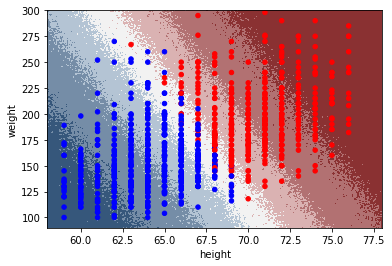

In [8]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
grid = np.mgrid[58:78:500j,90:300:500j]
grid2d = grid.reshape(2, -1)
grid_height = torch.tensor(grid2d[0])
grid_weight = torch.tensor(grid2d[1])
grid_sex_predict = [t for t,_, _ in posterior_predictive._traces(grid_height, grid_weight, sex=None)]
grid_sexes = torch.stack([t.nodes['sex']['value'] for t in grid_sex_predict]).mean(0)
sexes = torch.stack([t.nodes['sex']['value'] for t in test_sex_predict])
mean_sexes = (sexes.mean(0) > 0.5).data.numpy()
testdf = pd.DataFrame({'height': test_data['height'], 'weight': test_data['weight'],
                       'pred_sex': mean_sexes })
col = testdf['pred_sex'].map({1: 'r', 0: 'b'})
ax = testdf.plot.scatter(x='height', y='weight', color=col)
ax.contourf(grid[0], grid[1], grid_sexes.view(500, 500).numpy(), cmap=cmap, zorder=-1)